### This notebook presents code to accompany the paper

# A flexible data and knowledge-driven method for identifying climate drivers to predict summer conditions in China’s Northeast Farming Region 

In this work we collect around 30 different Climate Indexs, information on these can be found in `data/` read me file. To simplify the processing of all these seperate data files into one CSV, this has been done for you. The reason this has been left out is they are many different ways to process CSV files, we have used a combination of R and python for this and multiple people have been apart of this project. The format you're aiming for is seen below under `head(climate_indices)`. The dots actually get replaced with dashes so the column headers have the format `climate_index-month`. The other thing to watch out for here is the years, for example using a climate index in December 1981 to predict summer temperature 1981 doesn't make sense, as the summer comes first. Therefore we shifted this data, keeping everything in yearly rows for a simpler format. For example below when you see `wpsh-9` in the 1981 row, this is actually the WPSH in November 1980. Think of the index as the year we are looking to predict, that row contains climate indexs of the correct year to predict the year in the row index. 

This notebook contains all the nessacary methods to conduct this method:

### Section 1: Final Processing steps

* Standardising and detrending data 

### Section 2: Feature selection 

* Remove all features that are very poorly correlated with temperature or precip
* Run the rest through the random forest to find the most useful features 

### Section 3: Feature Refinement  

* Creating Bayseian Networks between selected Jets and Indices 
    
### Section 4 (not in this notebook): Dynamics Visualisation 
* See `./Dynamics/`

### Section 5: Creating predictive models 

* Linear Regression

## Section 1: Final Processing Steps 

* Standardising and detrending 

#### Detrending 

Firstly we detrend our data with a linear model. This ensures our data is stationary. We do this because of things like climate change, you can imagine that the temperature in NE has had an upward trend over the last 40 years or so. Detrending removes these trends so they are flat. 

#### Standardising 

Secondly we standardise our data, this sets the `mean = 0, standard deviation = 1` for each variable

In [1]:
temp_jja_fname = '../data/csv/temp_jja_NE_china.csv'
temp_jja = read.csv(paste(temp_jja_fname, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

In [2]:
climate_indices_fname = '../data/csv/joined_climate_indicies.csv'
climate_indices = read.csv(paste(climate_indices_fname, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

* Using `head()` to view the first 5 rows of our dataframe 

In [3]:
head(temp_jja)

,Liaoning,Jilin,Heilongjiang
,<dbl>,<dbl>,<dbl>
1981,22.61073,21.62084,20.11407
1982,22.96797,22.92326,21.90634
1983,22.26246,20.61599,19.13693
1984,22.61542,21.94940,20.54990
1985,22.32568,21.85647,20.67396
1986,21.77447,21.17251,20.37019


In [4]:
head(climate_indices)

,wpsh.9,wpsh.10,wpsh.11,wpsh.12,wpsh.1,wpsh.2,wpsh.3,wpsh.4,wpsh.5,iod.9,⋯,mjopc2a.5,amo.9,amo.10,amo.11,amo.12,amo.1,amo.2,amo.3,amo.4,amo.5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,14647.72,14855.22,14874.19,14754.29,14840.38,14823.92,14974.42,14865.94,14733.79,-0.639,⋯,0.3135853,-0.14,-0.15,-0.15,-0.15,-0.15,-0.16,-0.16,-0.16,-0.16
1982,14724.16,14813.61,14881.97,14928.39,14844.86,14816.04,14831.94,14822.94,14803.69,-0.651,⋯,-0.8869489,-0.16,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.16,-0.16
1983,14697.37,14787.07,15000.44,14983.69,15086.88,14982.15,14953.99,14939.12,14837.90,0.548,⋯,-1.2200562,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16
1984,14788.31,14886.98,14866.77,14894.84,14774.50,14744.34,14836.41,14743.72,14685.91,0.037,⋯,1.0038773,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15
1985,14756.51,14682.57,14898.16,14755.96,14815.74,14657.85,14918.78,14622.10,14663.60,-0.502,⋯,0.9774278,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.16
1986,14790.06,14870.71,14887.35,14840.96,14812.80,14745.91,14785.91,14862.11,14621.19,-0.132,⋯,-0.3579582,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.17,-0.17


In [5]:
colnames(climate_indices) <- gsub("[[:punct:]]", "-", colnames(climate_indices))

* See how the WPSH has very different values to the iod, or our temperature values 
* These currently arent comparable so we need to standardise

* Next we make a list of indices and months we want to know about
    * This can change based on previous runs of this code 
* We also create some information about each climate index, for example if it orginates in the tropics or high latitudes

In [6]:
mon_list = c(9,10,11,12,1,2,3,4,5)

In [7]:
ind_list = c("wpsh", "iod", "pdo", "nin3","seu", "nao", "snao", "scand", "ao", "eawr", "peu", "cgt", "pstratu", "mjopc1a", "mjopc2a", "amo")
ind_list_rep = rep(ind_list, each=length(mon_list)) # creates ind_list with names the length of the month i
index_type = c("Tropical", "Tropical", "Mid-lat", "Tropical", "High-lat", "Mid-lat", "Mid-lat", "High-lat", "High-lat", "High-lat", "High-lat", "Mid-lat", "Polar-strat", "Tropical", "Tropical", "Mid-lat")
data.class = rep(index_type, each=length(mon_list))

* We use this information to create an empty dataframe, that we will fill with the detrended values

In [8]:
cindex_df = array(NA, c(dim(climate_indices)[1], dim(climate_indices)[2]))
colnames(cindex_df) = colnames(climate_indices)
rownames(cindex_df) = rownames(climate_indices)

names(data.class) = index_type

* Now we loop through each column, detrend and standardise 
    * we detrend with a simple linear regression: the `lm` function 
    * we standardise the data with the `scale` function 

In [9]:
for (s in 1:dim(climate_indices)[2]) {
  # de-trend
  tt = 1:dim(climate_indices)[1]
  mod = lm(climate_indices[,s] ~ tt)
  cindex_df[,s] = scale(mod$residual)
}

In [10]:
head(cindex_df)

,wpsh-9,wpsh-10,wpsh-11,wpsh-12,wpsh-1,wpsh-2,wpsh-3,wpsh-4,wpsh-5,iod-9,⋯,mjopc2a-5,amo-9,amo-10,amo-11,amo-12,amo-1,amo-2,amo-3,amo-4,amo-5
1981,-0.81403246,0.3908544,-0.4832602,-1.79450205,-0.5490223,-0.2333582,1.1935139,0.60339529,-0.1832748,-1.201899209,⋯,0.2940131,1.299626222,1.14105248,1.0942301,1.05689299,1.03964024,0.90265360,0.88897409,0.7729054,0.75323034
1982,0.27045373,-0.1548922,-0.3574754,0.08064204,-0.5024673,-0.3294853,-0.5197873,0.07973675,0.7816871,-1.263696128,⋯,-1.3135036,0.762324208,0.60299290,0.5619158,0.52692667,0.51459353,0.54373150,0.52593390,0.6010720,0.58203490
1983,-0.09435666,-0.5000170,1.6245257,0.67717440,2.4069856,1.3393430,0.9469850,1.46479417,1.2537764,1.890814598,⋯,-1.7531080,0.573753485,0.58878967,0.5485361,0.51414677,0.50180359,0.52872662,0.51198378,0.4292385,0.41083947
1984,1.19371570,0.8395346,-0.6218910,-0.27775697,-1.3654123,-1.0892955,-0.4670106,-0.88611513,-0.8449340,0.503718327,⋯,1.2501129,0.559548407,0.57458645,0.5351565,0.50136687,0.48901366,0.51372174,0.49803365,0.4215489,0.40374329
1985,0.75847369,-1.8752372,-0.1000867,-1.77105230,-0.8759027,-1.9828740,0.5227434,-2.35231562,-1.1530700,-0.957743439,⋯,1.2233955,0.370977684,0.38576443,0.3487986,0.31619150,0.30547146,0.32675824,0.30953850,0.2497155,0.06844861
1986,1.24078063,0.6398621,-0.2861184,-0.85493696,-0.9188377,-1.1057450,-1.0751083,0.51735794,-1.7388319,-0.004982538,⋯,-0.5656869,0.008041316,0.02232364,-0.0105375,-0.04137935,-0.04882299,-0.03216386,-0.05350168,-0.2504056,-0.26684608


* Now we have detended the climate indices we need to do the same for our regional temperature data 

In [11]:
temp_anoms = array(NA, c(dim(temp_jja)[1], dim(temp_jja)[2]))
colnames(temp_anoms) = paste(colnames(temp_jja),"-T", sep="")

In [12]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA


* Same for loop again but for the temp and precip data 

In [13]:
for (k in 1:length(colnames(temp_anoms))) {
  print(colnames(temp_anoms)[k])
  tt = 1:length(temp_jja[,k])
  lmmodt = lm(temp_jja[,k] ~ tt)
  temp_anoms[,k] = scale(lmmodt$residuals)
}  

[1] "Liaoning-T"
[1] "Jilin-T"
[1] "Heilongjiang-T"


In [14]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
0.4767537,-0.07799843,-0.53412111
1.0461054,1.81619148,2.06508026
-0.1926158,-1.65087332,-2.06402876
0.3694542,0.28934417,-0.02428095
-0.1619110,0.11110493,0.11437196
-1.1381192,-0.94495550,-0.37800865


## Section 2: Feature selection 

* Remove all features that are very poorly correlated with temperature or precip
* Run the rest through the random forest to find the most useful features 

#### Correlations 

We calculate a crictical correlation value given the number of observations using `critical.r`. This function returns a value the correlions of our variables need to pass with two degrees of freedom and an alpha (p value) of 0.15 ( a 15% sigificance value should be an easy test to pass, remember we are only trying to remove really poorly correlated variables). 

We also correlate our climate indicies with the temperature and precip we are trying to predict. We then select all the indicies which pass this test. This cuts our set of variables down a lot and removes ones with minimal information. 

#### Random Forest 

We use a random forest regression model from the `Boruta` package. 

In [15]:
critical.r <- function(n, alpha) {
  df <- n - 2
  critical.t <- qt( alpha/2, df, lower.tail = F )
  critical.r <- sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
  return( critical.r )
}

* Correlating our indicies and temperature data 

In [16]:
indt = cor(cindex_df, temp_anoms)

* Calculate critical R value for our data with ` n = length(rownames(cindex_df)` degrees of freedom and a 0.15 significance level 
* 0.15 is selected to be easy to pass on purpose so we only exclude really bad predictors

In [17]:
corr_crit = critical.r(length(rownames(cindex_df)), 0.15)

In [18]:
corr_crit

[1] 0.2448937

* Using this critical value to rule out some indicies that have a correlation lower than this 
* We store their indexs
* Remember these are just indicies that pass a low significance level

In [19]:
important_temp_indexs = unique(which(abs(indt) >= corr_crit, arr.ind=TRUE)[,1])

In [20]:
important_temp_indexs

[1]   5  12  16  17  18  38  39  41  55  57  58  64  71  82  83  85  88  92  94
[20]  96  97 103 108 110 111 112 114 121 123 130 132   3   6  32  33  34  35  36
[39]  50 106 107 117 118 122 124 127 131 133   7  14  29  30  31  45  74 100

* Get their names 

In [21]:
important_temp_names = colnames(cindex_df)[important_temp_indexs]

In [22]:
important_temp_names

[1] "wpsh-1"     "iod-11"     "iod-3"      "iod-4"      "iod-5"     
 [6] "seu-10"     "seu-11"     "seu-1"      "snao-9"     "snao-11"   
[11] "snao-12"    "scand-9"    "scand-4"    "eawr-9"     "eawr-10"   
[16] "eawr-12"    "eawr-3"     "peu-10"     "peu-12"     "peu-2"     
[21] "peu-3"      "cgt-12"     "cgt-5"      "pstratu-10" "pstratu-11"
[26] "pstratu-12" "pstratu-2"  "mjopc1a-12" "mjopc1a-2"  "mjopc2a-12"
[31] "mjopc2a-2"  "wpsh-11"    "wpsh-2"     "nin3-1"     "nin3-2"    
[36] "nin3-3"     "nin3-4"     "nin3-5"     "nao-1"      "cgt-3"     
[41] "cgt-4"      "pstratu-5"  "mjopc1a-9"  "mjopc1a-1"  "mjopc1a-3" 
[46] "mjopc2a-9"  "mjopc2a-1"  "mjopc2a-3"  "wpsh-3"     "iod-1"     
[51] "nin3-10"    "nin3-11"    "nin3-12"    "seu-5"      "ao-10"     
[56] "cgt-9"

### Feature selection using random forests 

* To do this we will use the `Boruta` package 

In [23]:
library(Boruta)
library(ggplot2)

* Make a list of our regions to loop through 

In [24]:
region = "NE_China"
regs = c("Liaoning", "Jilin", "Heilongjiang")

In [25]:
# setting up stuff for saving
lag = 0 
ystrts = rownames(cindex_df)[1] # first year in dataset 
yends = rownames(cindex_df)[length(rownames(cindex_df))] # last year in dataset 
suffix = 'jja'

In [26]:
dx = 1+dim(cindex_df)[2]
# need a column for the intercepts
sub= 2:dx

coef_array_full = array(0, c(length(regs),4,dx))
dimnames(coef_array_full)[[3]] <- c("Intercept", colnames(cindex_df))
dimnames(coef_array_full)[[1]] <- regs

In [27]:
library(IRdisplay)

In [28]:
regs

[1] "Liaoning"     "Jilin"        "Heilongjiang"

In [29]:
do_boruta_feature_selection <- function(y_train, data) {
    boruta_output <- Boruta(y_train ~ ., data=data, doTrace=0, maxRuns= 400, ntree=4000, pValue = 0.01)
    boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
    
    return(boruta_output, boruta_signif)
} 

top10_correlations_df <- function(ind, k) {
    c_inds = order(-abs(ind[,k]))[1:10]
    c_names = row.names(ind)[order(-abs(ind[,1]))][1:10]
    c_df = data.frame(feature = c_names,
                   importance = abs(ind[c_inds,k]))
    
    return(c_df)
    
}

plot_10_correlations <- function( df, region_name, T_or_P, filename) {
    ggplot(data = df, 
    aes(x = reorder(feature, -importance), y = importance, fill = feature)) +
    geom_bar(stat="identity") + labs(x = "Features", y = "Correlation") +
    geom_text(aes(label = round(importance, 2)), vjust=1.6, color="white", size=4) + 
    theme_bw() + theme(legend.position = "none") + ggtitle(paste('Feature correlated with ',T_or_P ,region_name))
    ggsave(filename, width=6, height=4)
}

[1] "Liaoning"
[1] 1


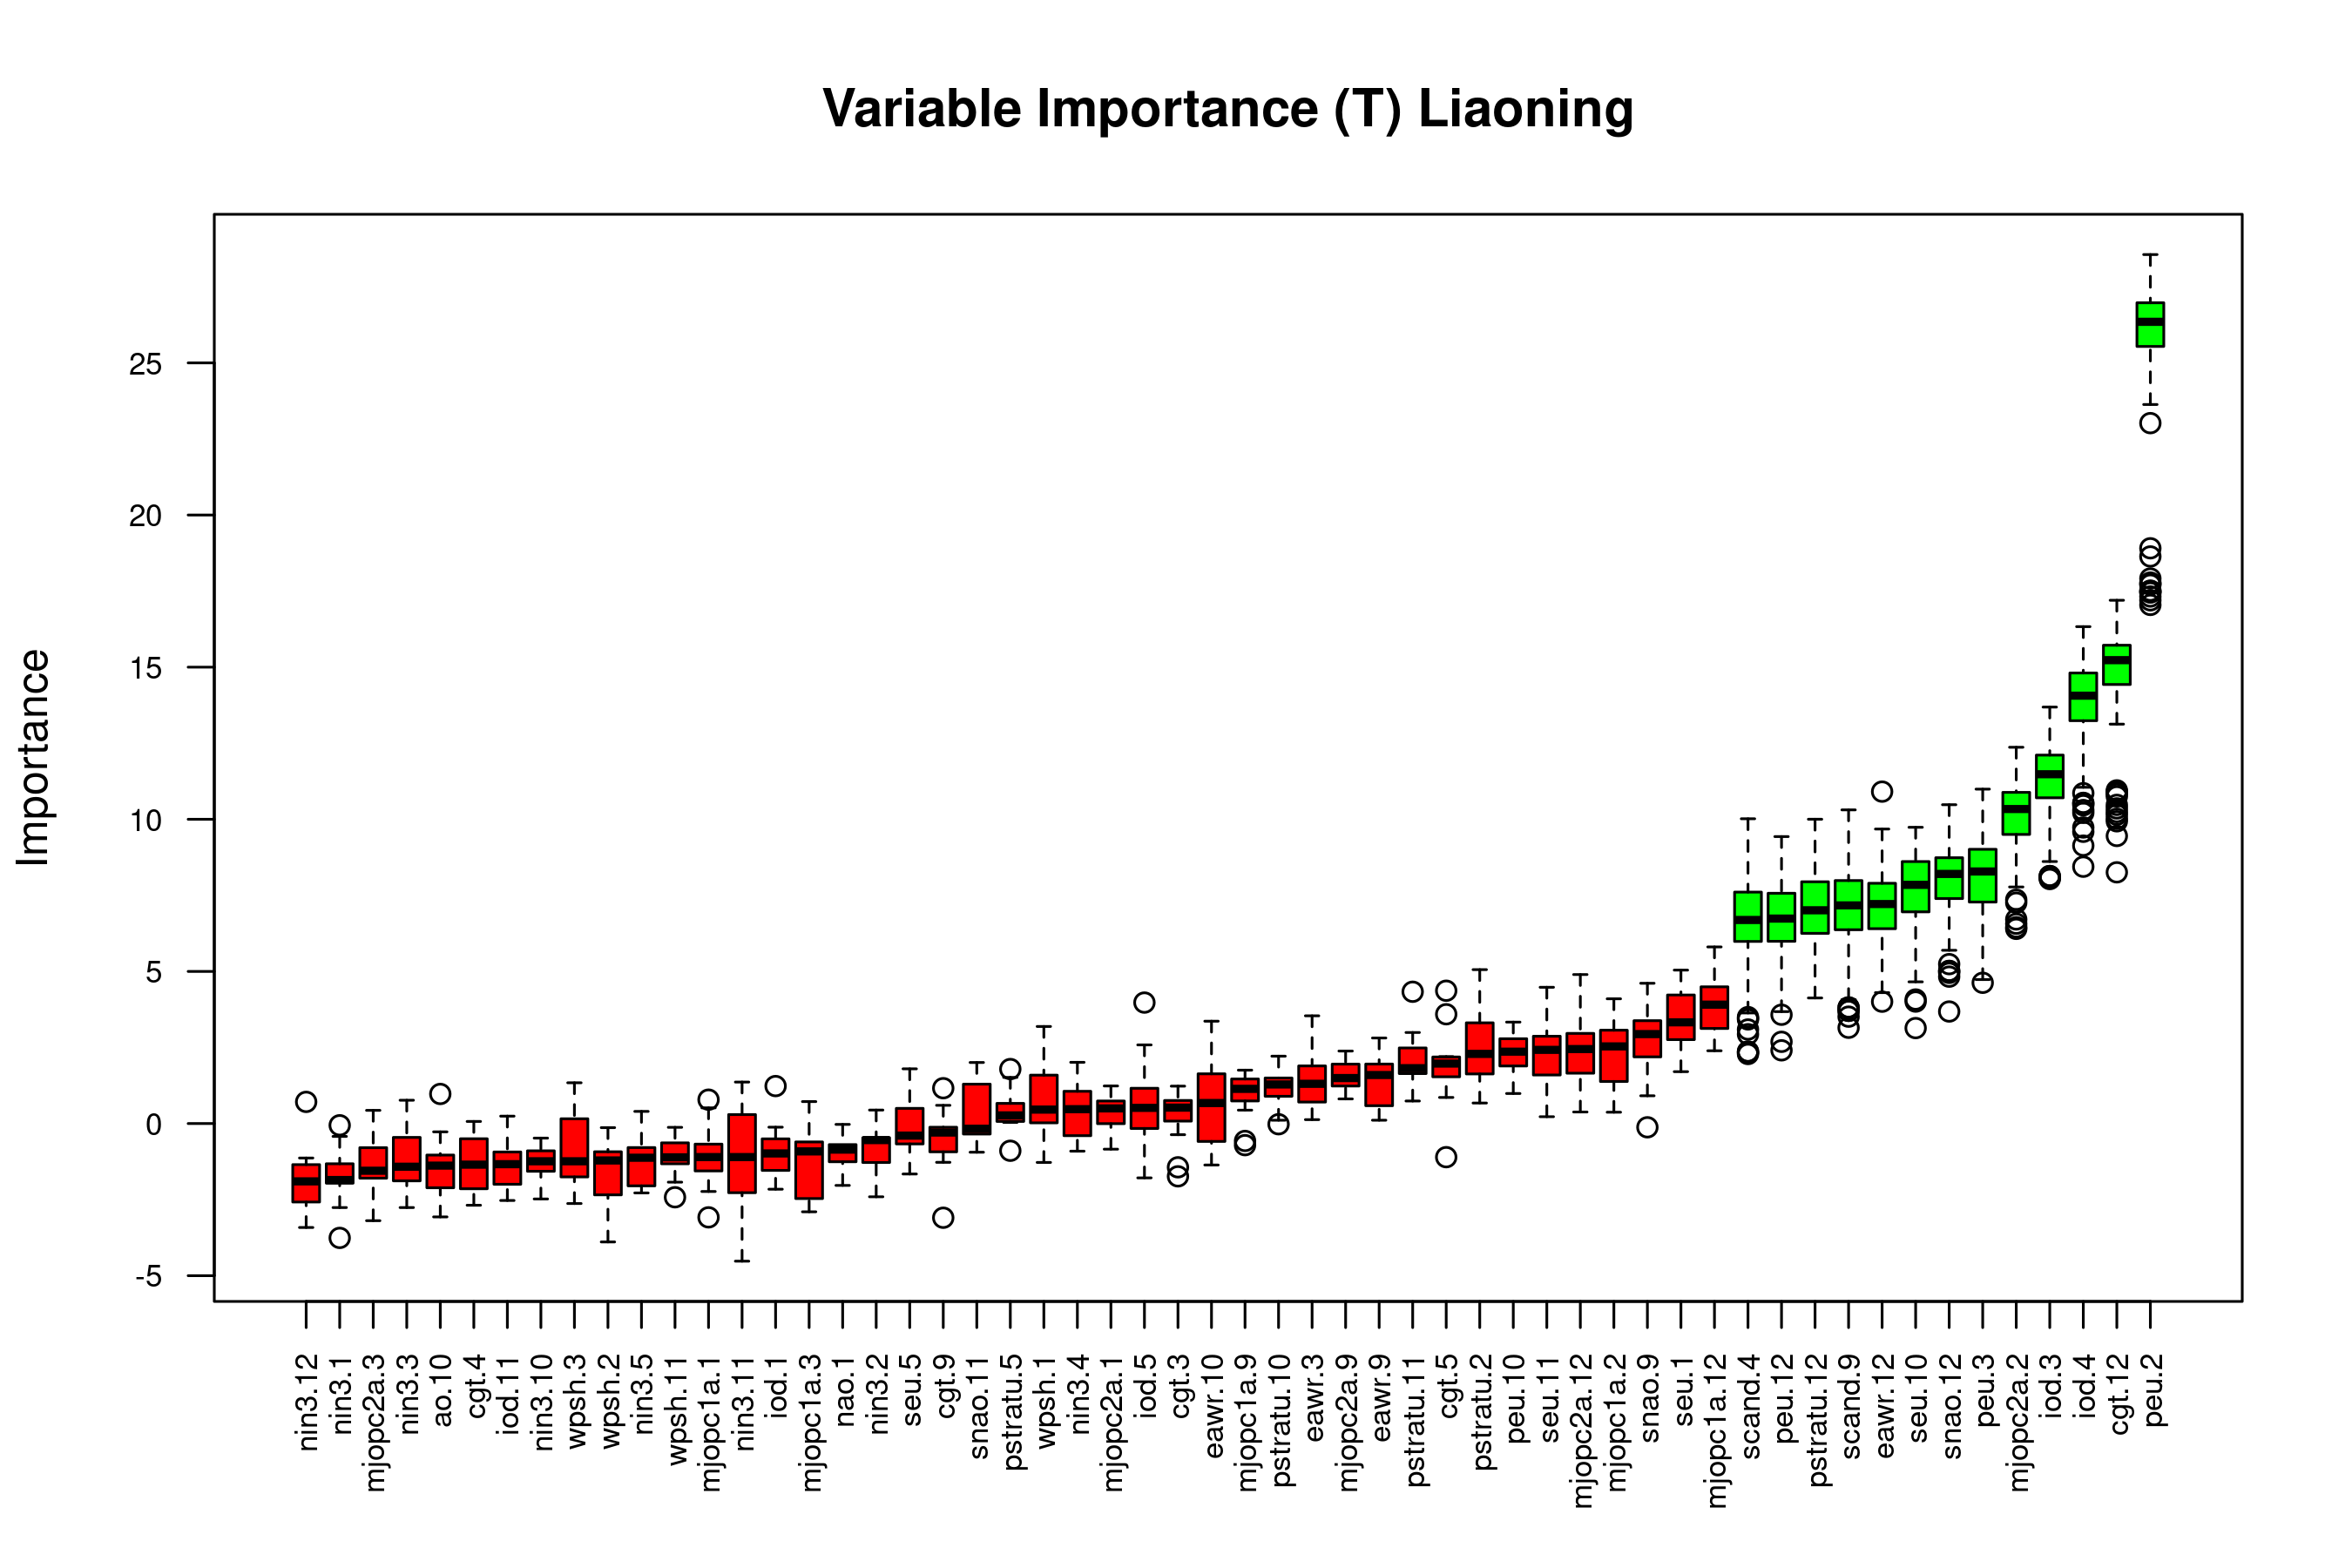

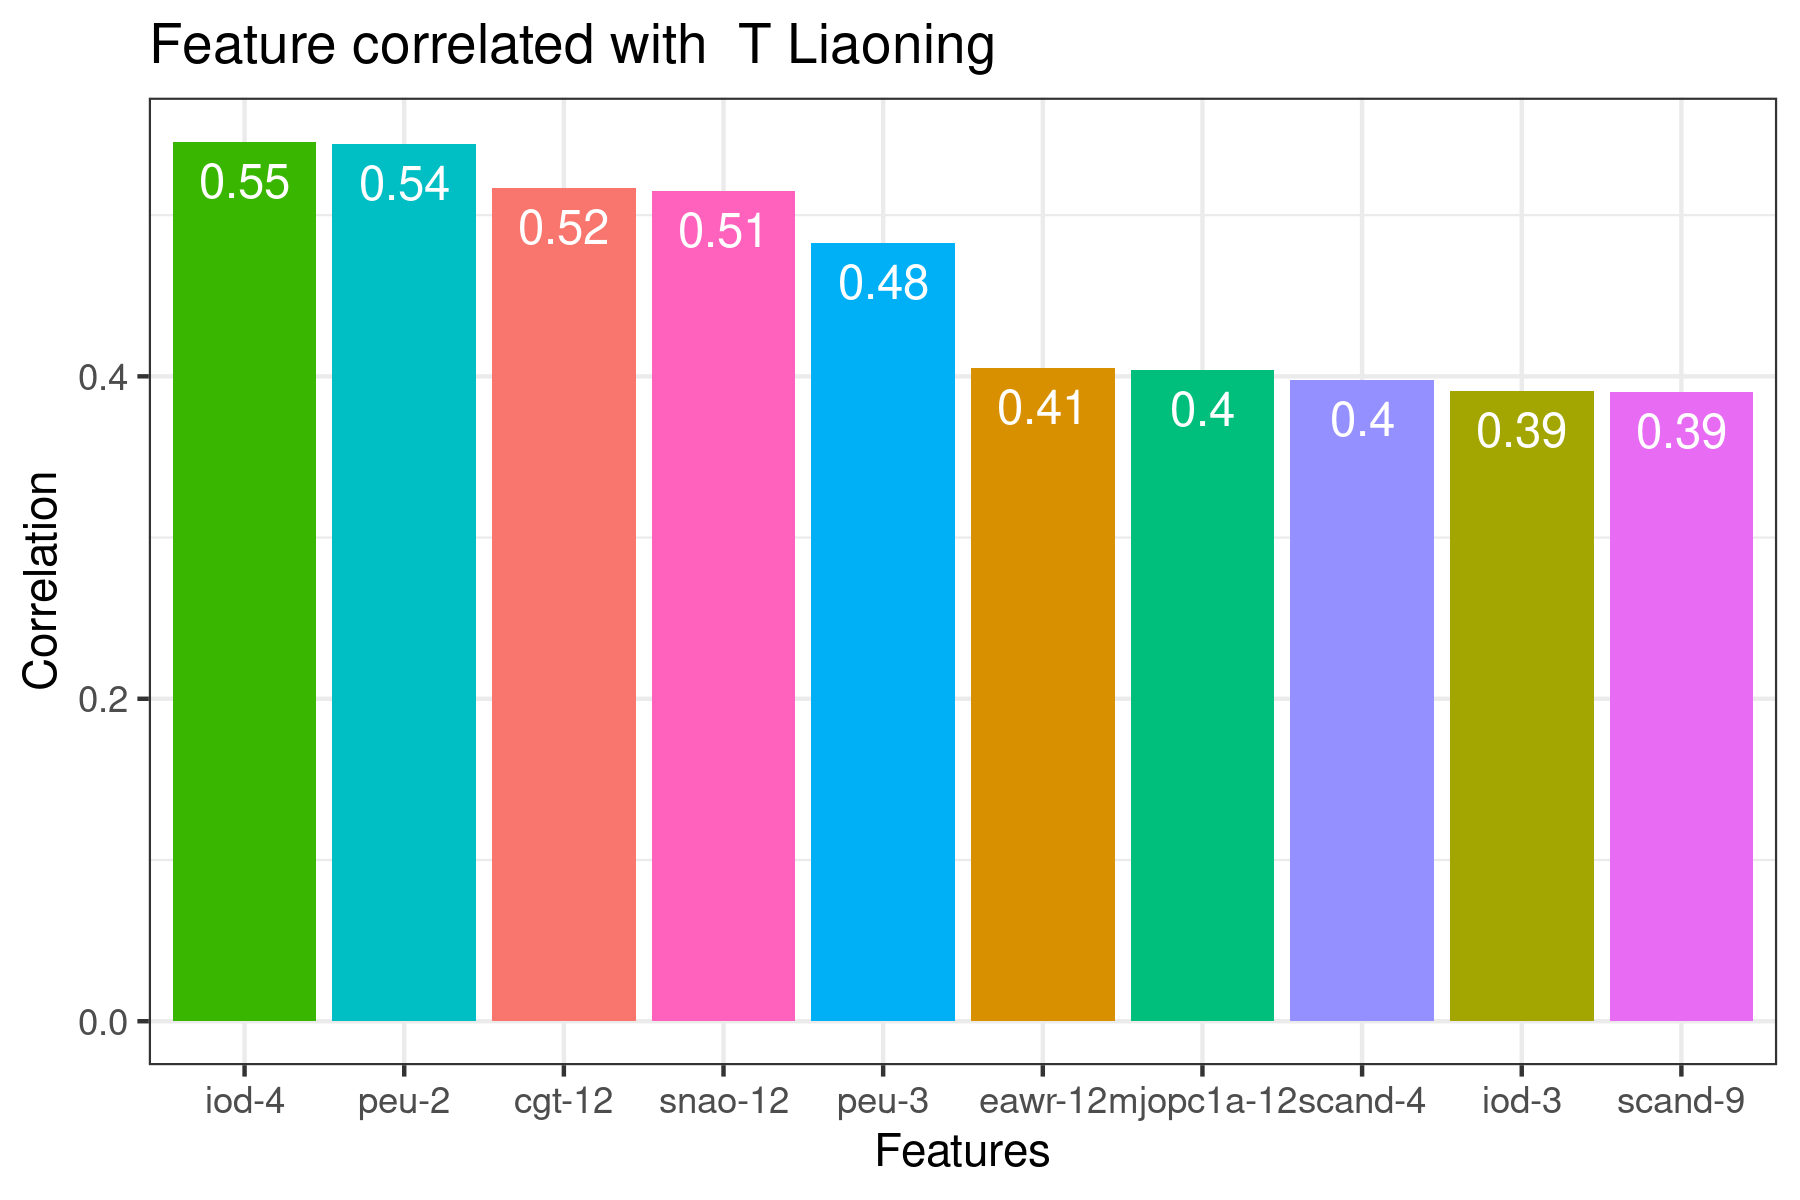

[1] "Jilin"
[1] 2


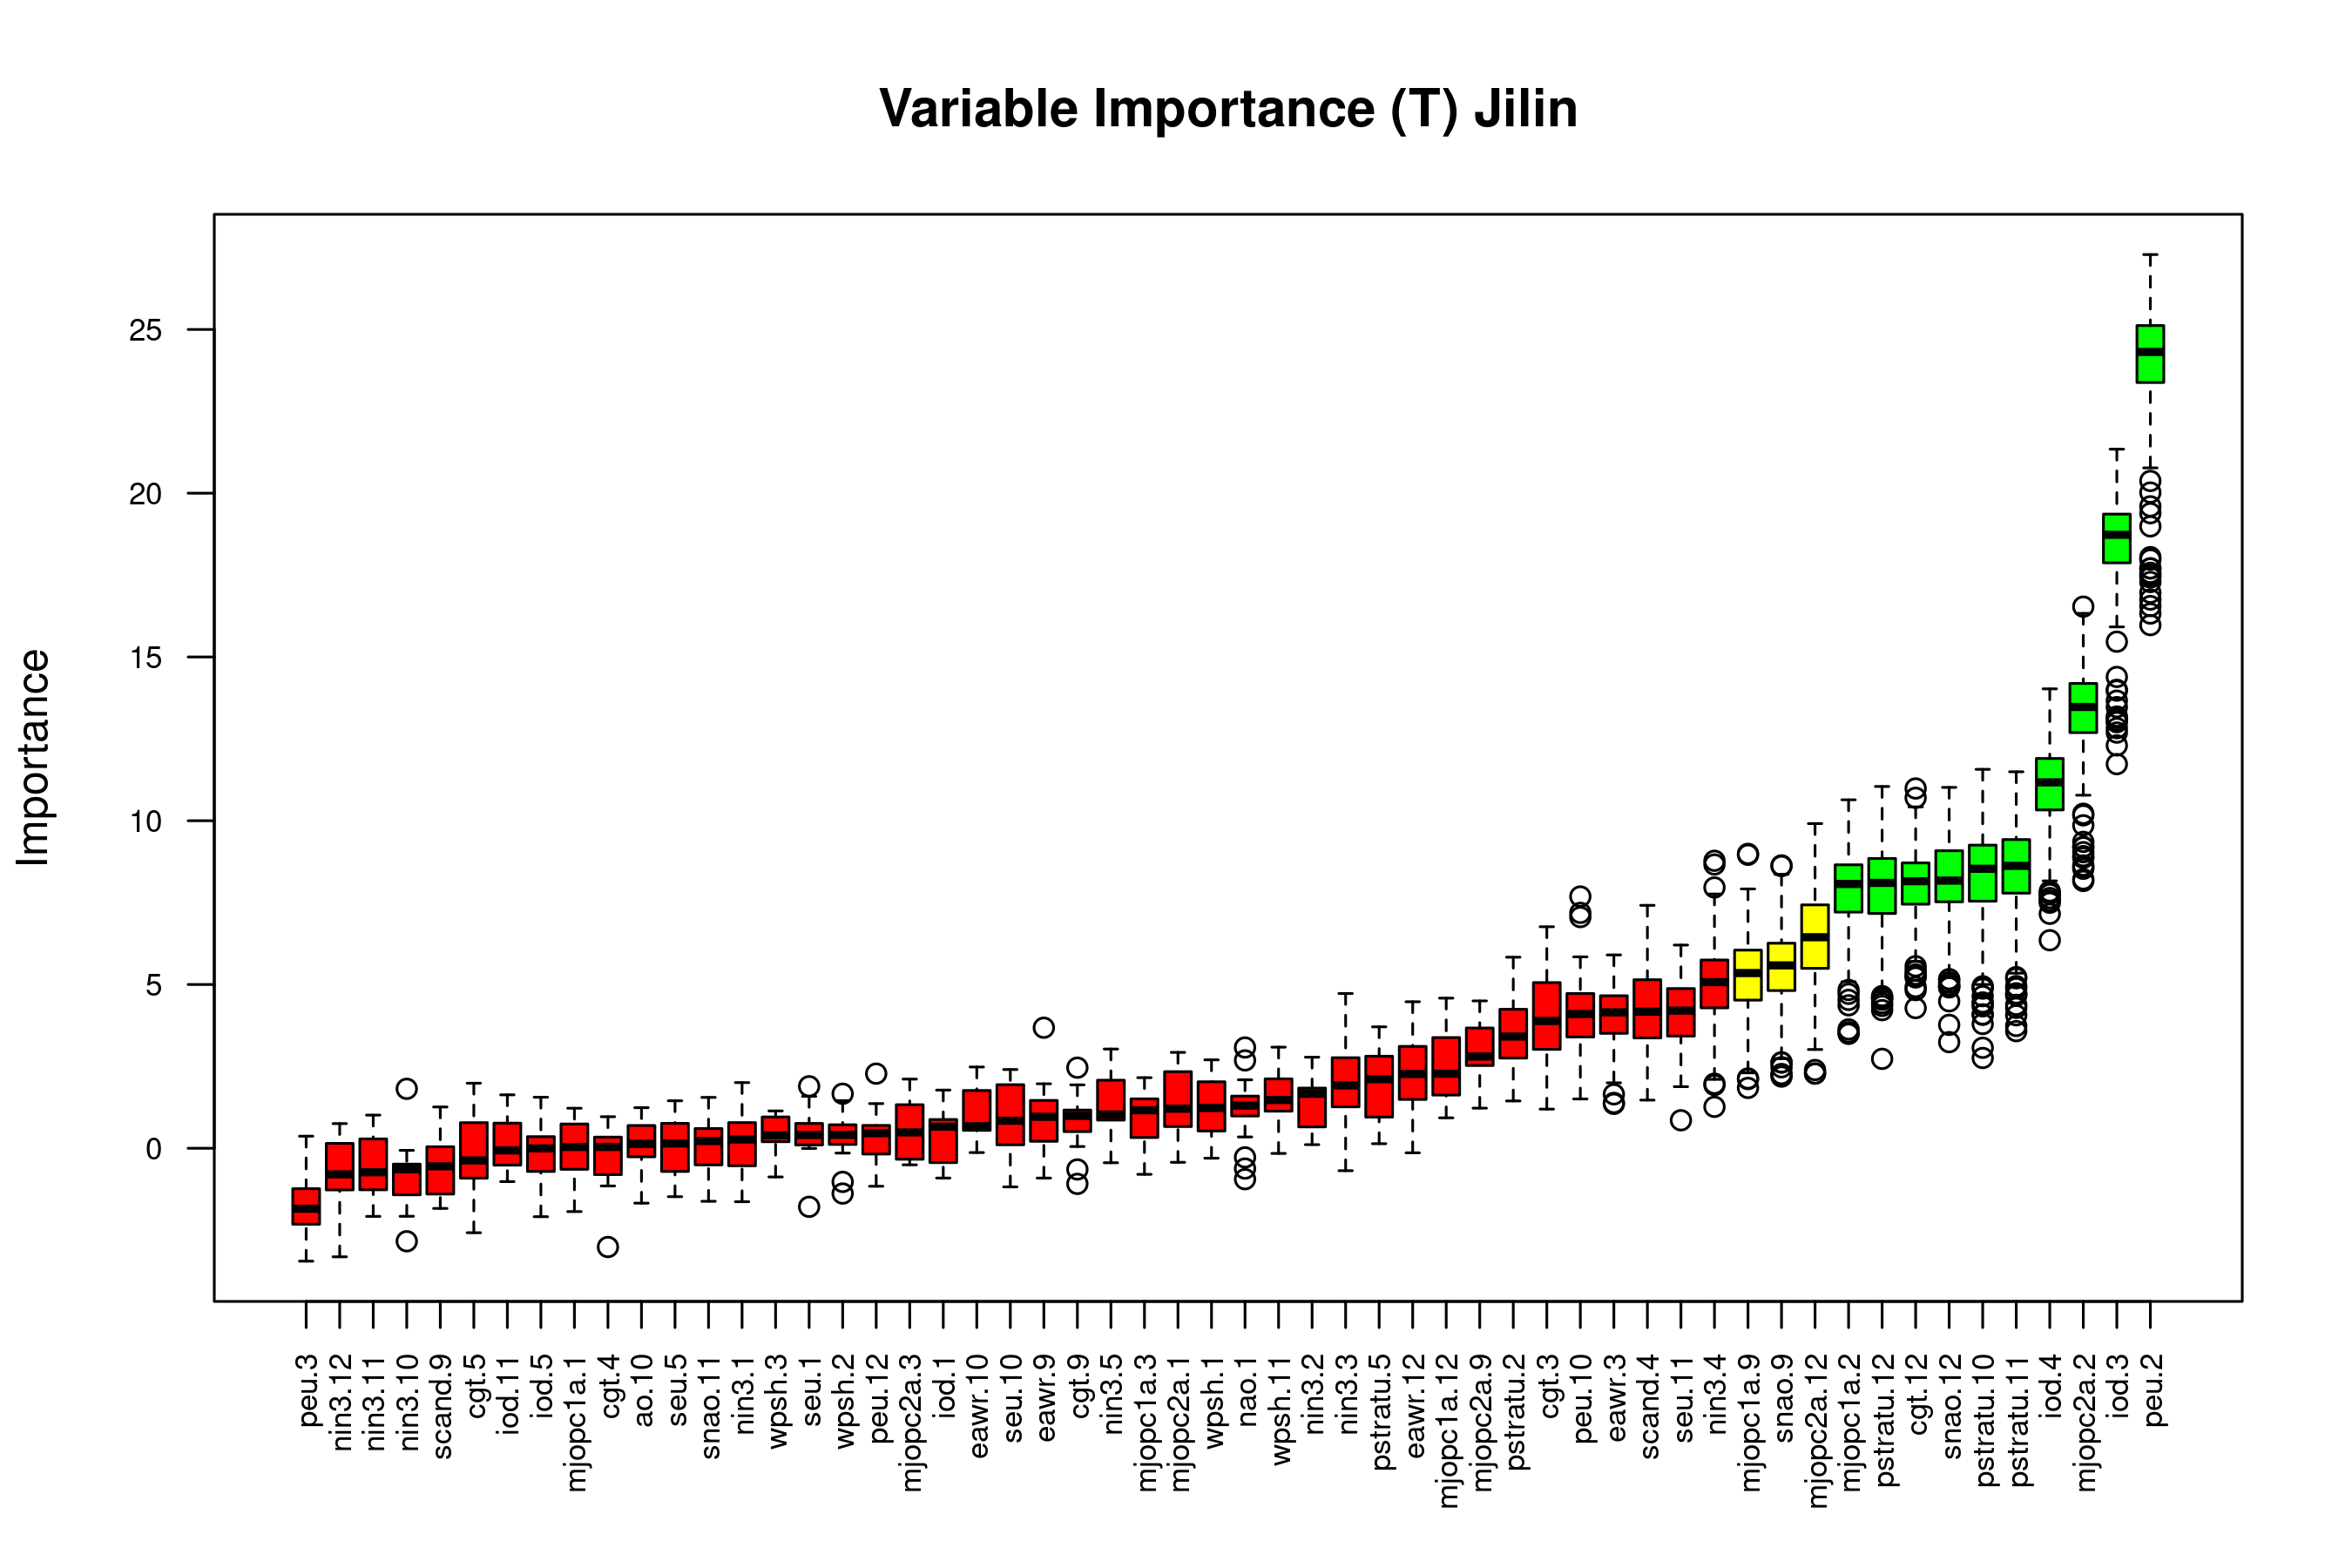

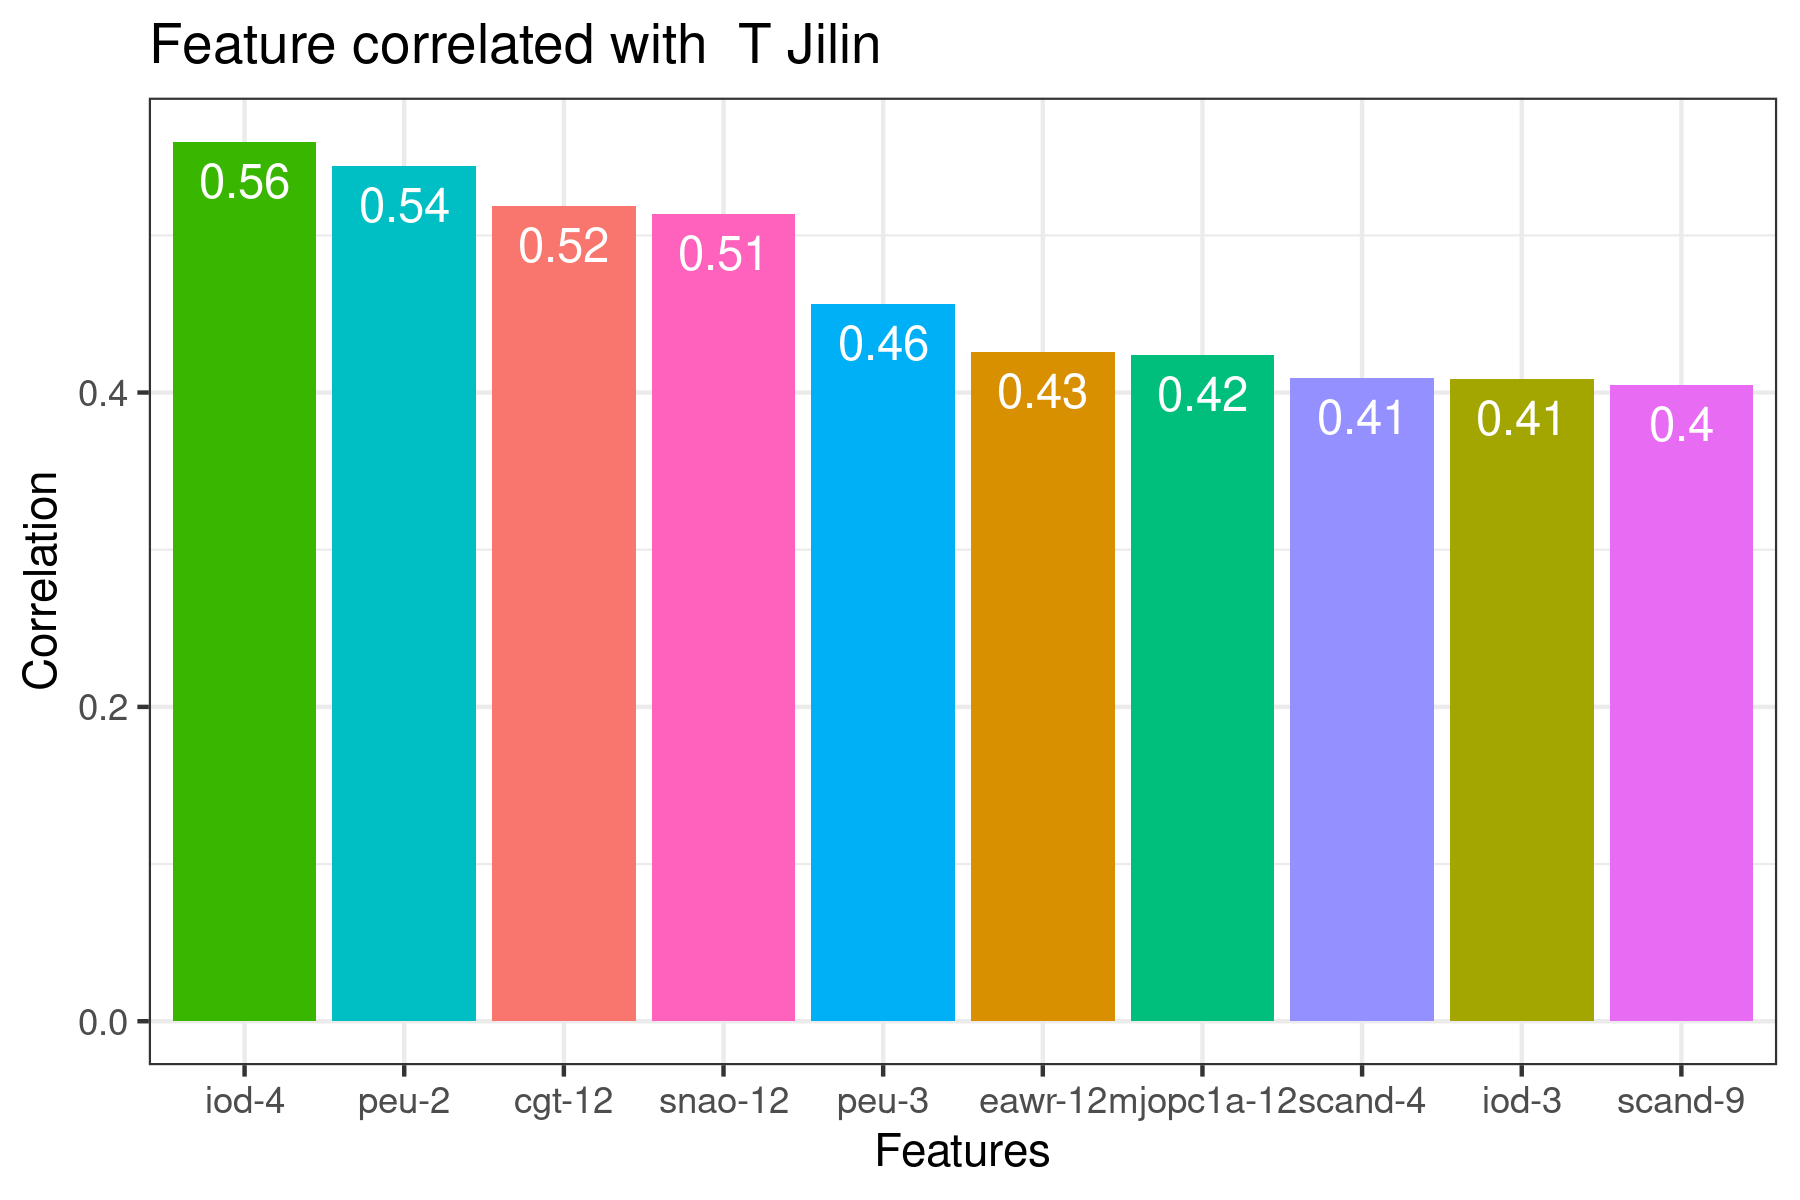

[1] "Heilongjiang"
[1] 3


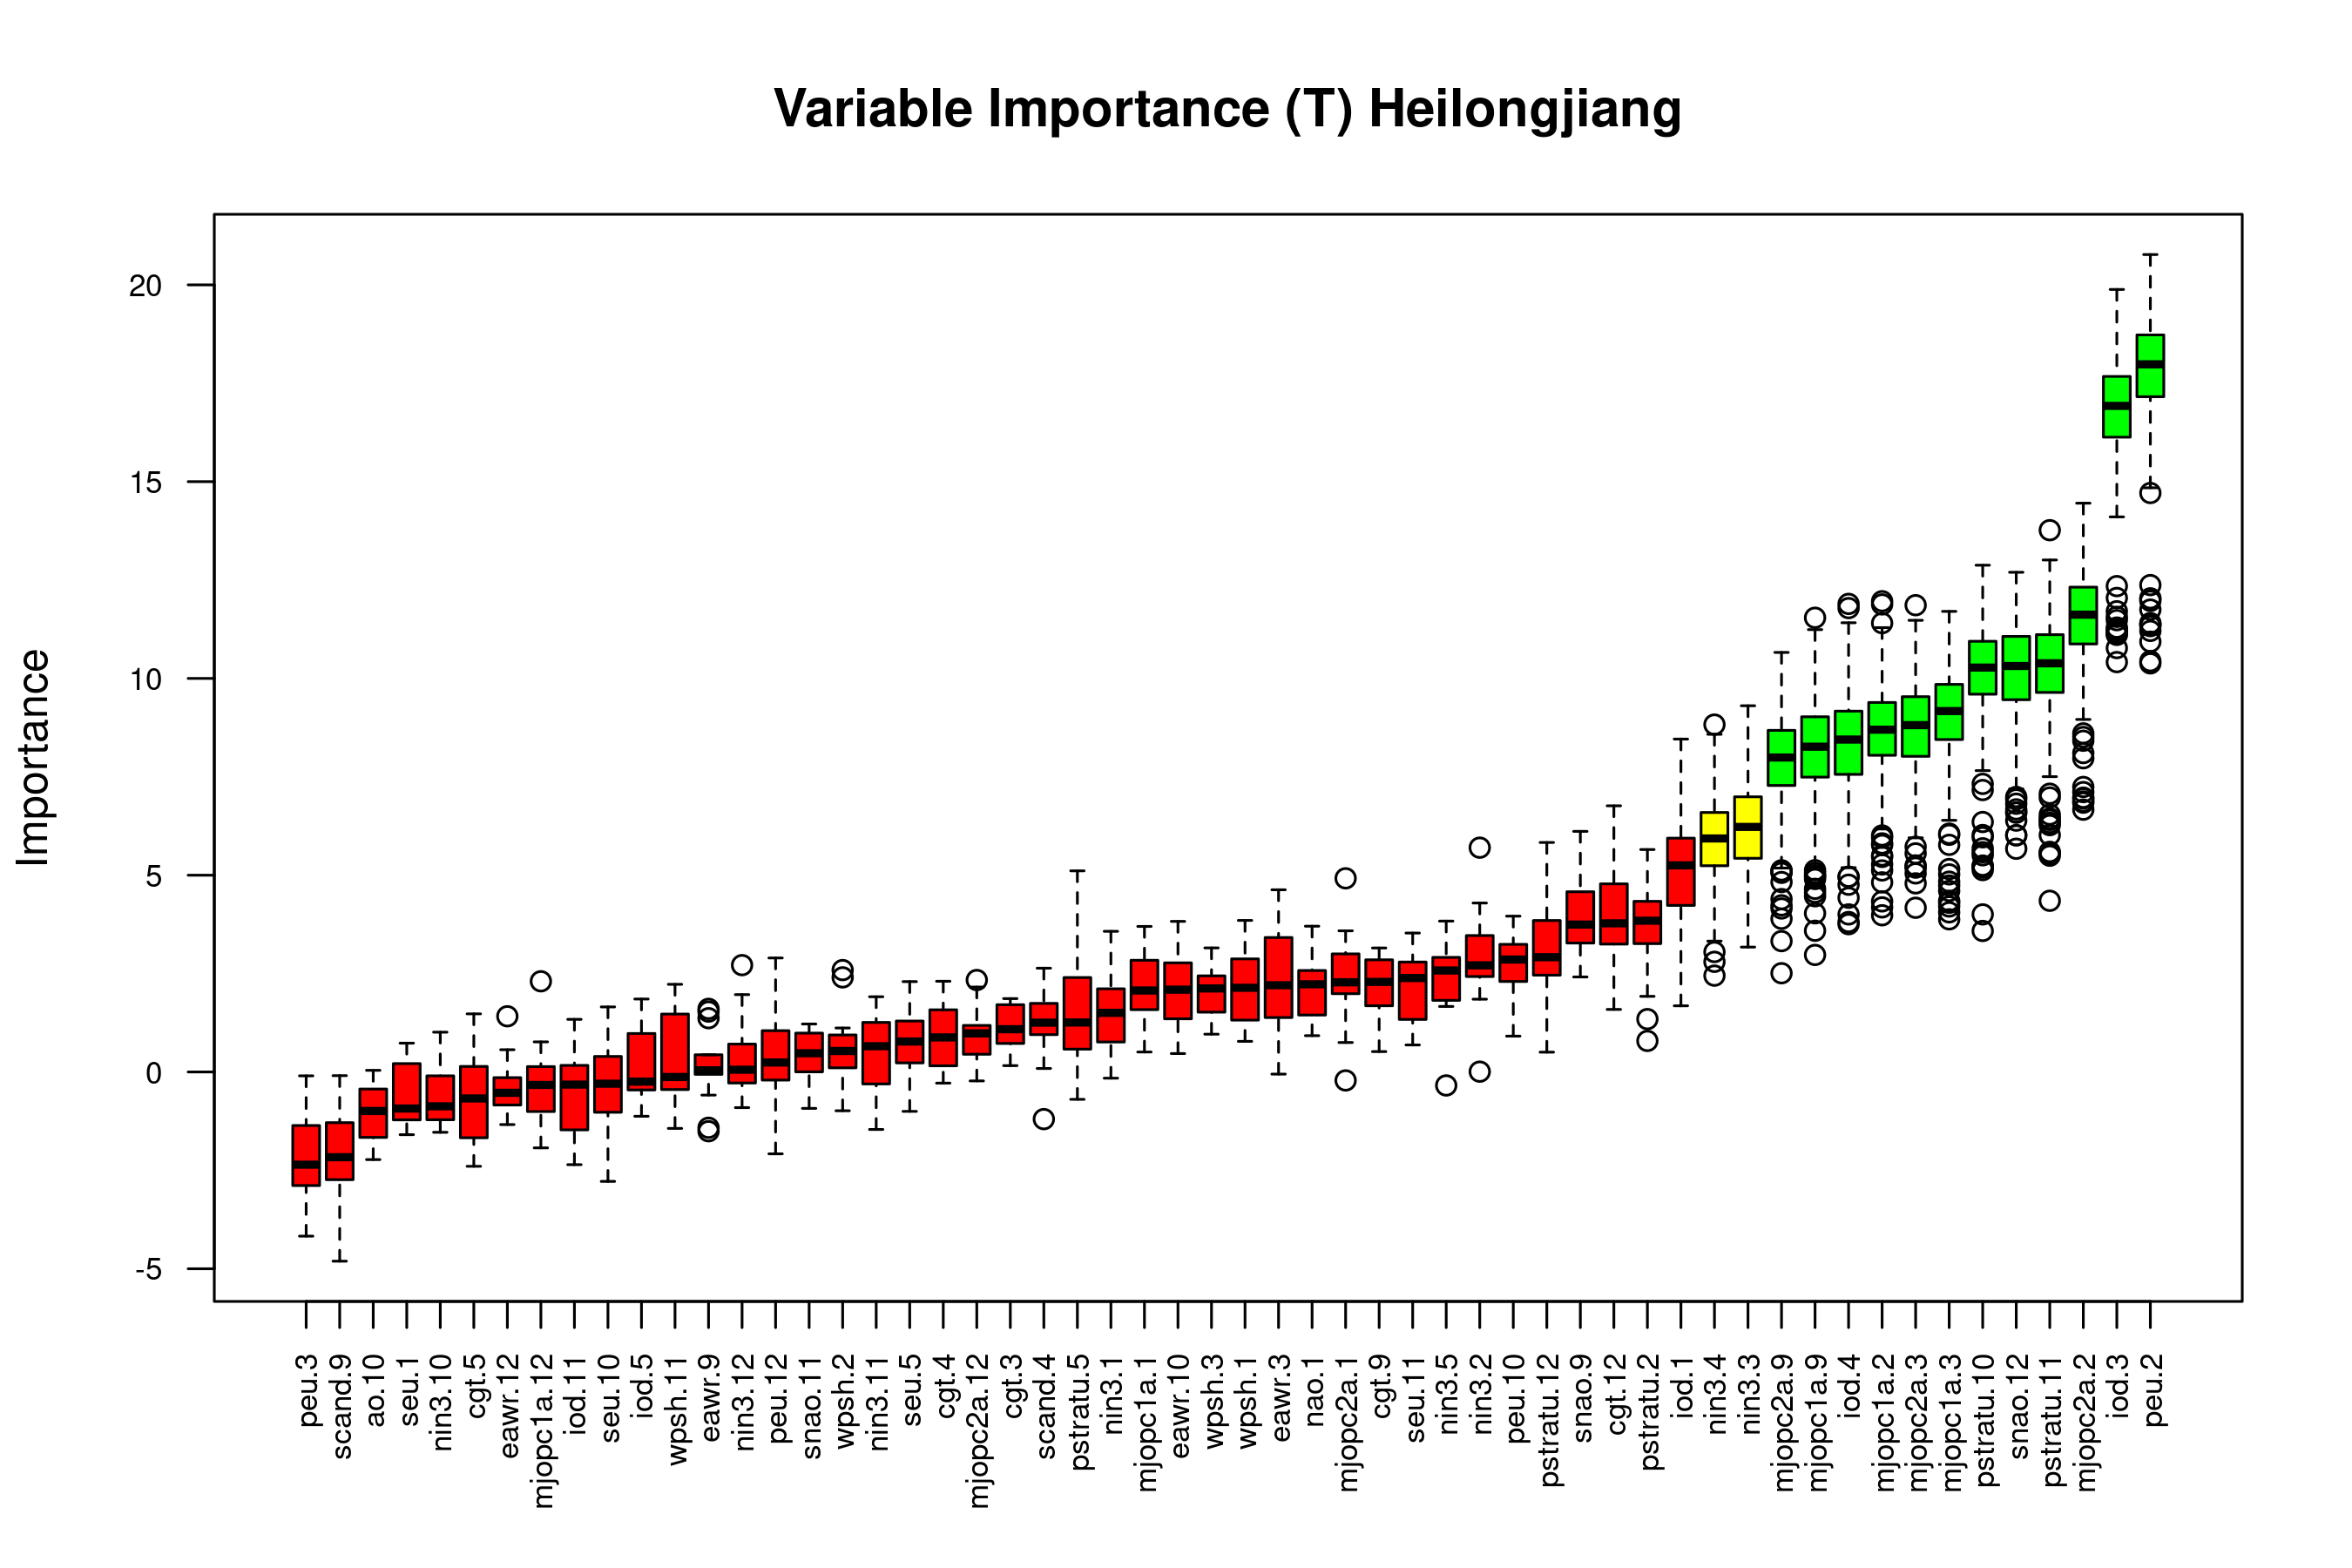

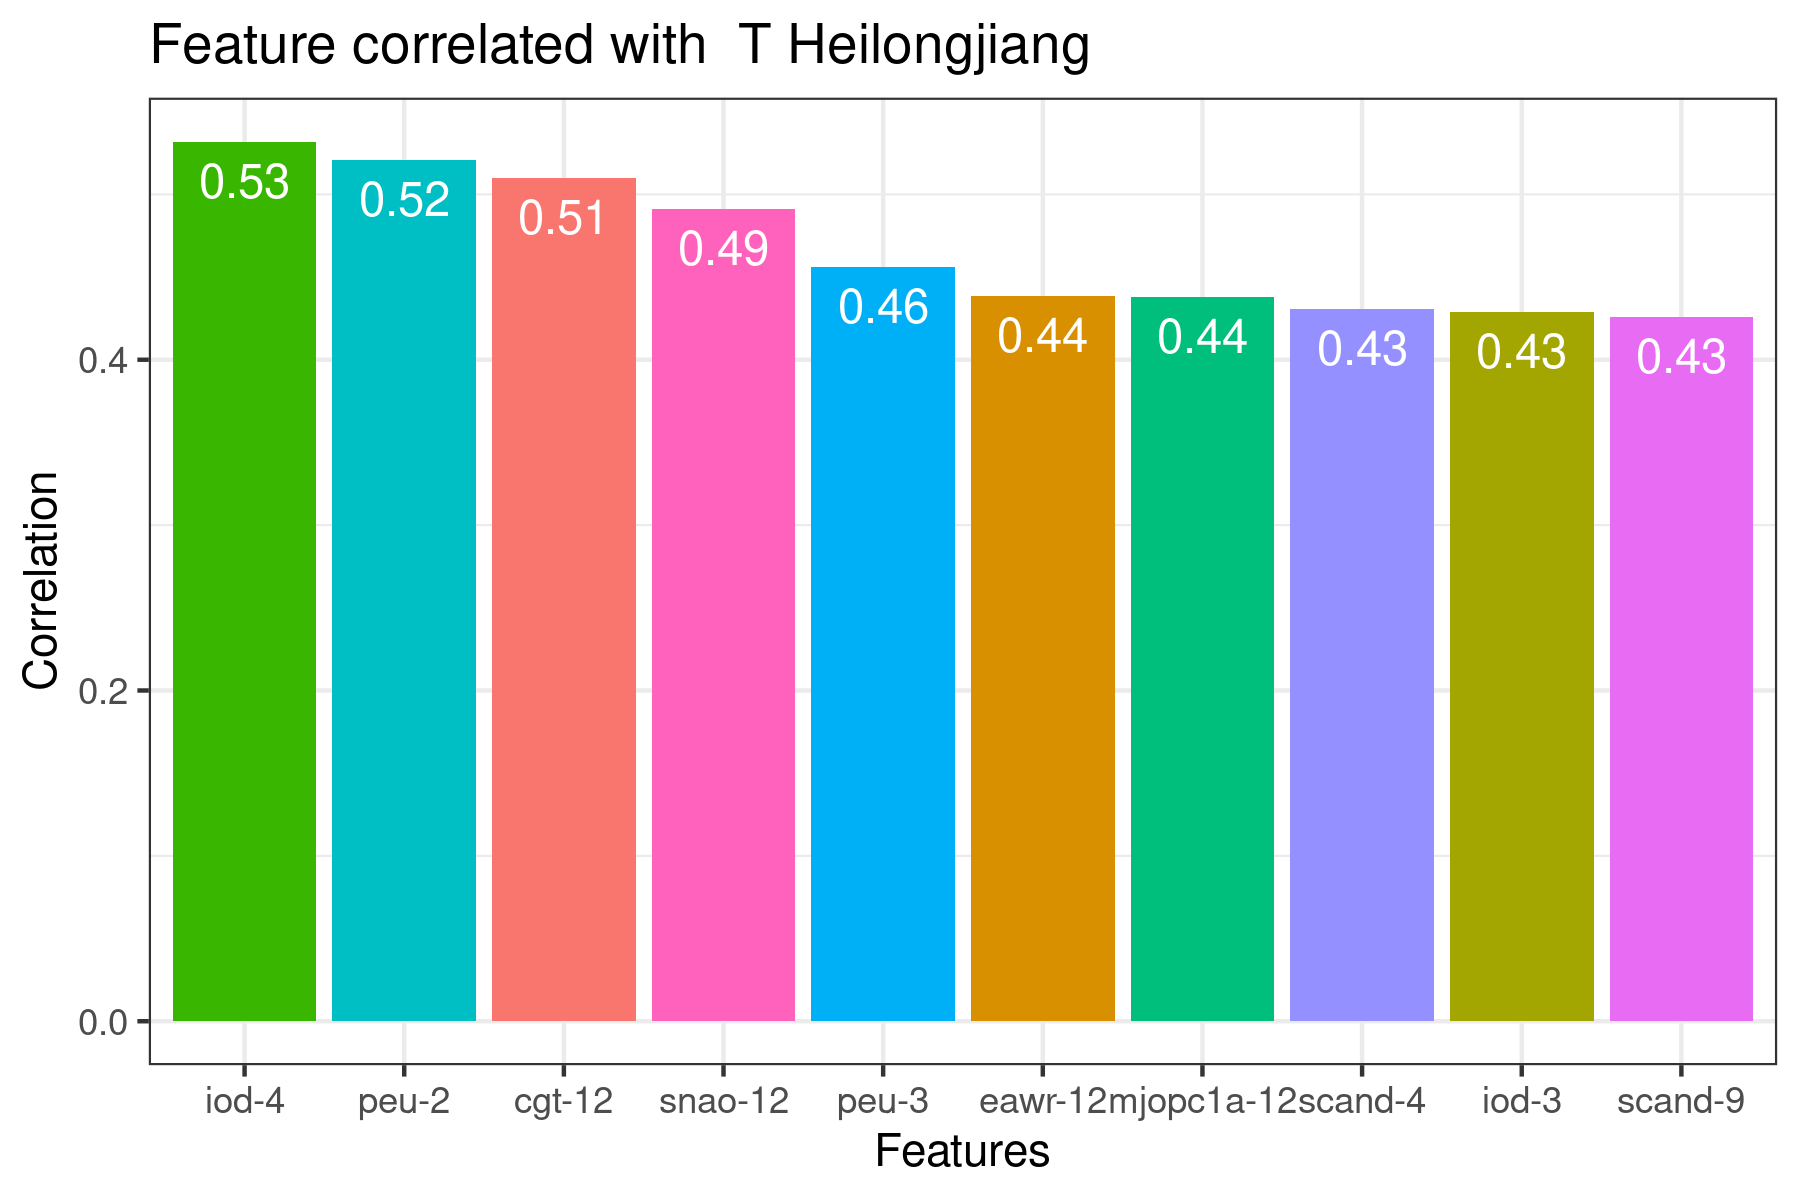

In [37]:
temp_x_train <- cindex_df[, important_temp_names]

sub = 2:(length(colnames(cindex_df)) + 1)

for (k in 1:length(regs)) {
    print(regs[k])
    print(k)
    temp_y_train <- temp_anoms[ ,k]
    
    set.seed(1)
    
    din_temp  = data.frame(cbind(temp_x_train, temp_y_train)) 

    pcrit = 0.05

    ts = array(NA, length(colnames(cindex_df)))
    
    ########################## Doing feature selection with random forest #######################################
    
    boruta_output_temp <- Boruta(temp_y_train ~ ., data=din_temp, doTrace=0, maxRuns= 400, ntree=4000, pValue = 0.01)
    boruta_signif_temp <- names(boruta_output_temp$finalDecision[boruta_output_temp$finalDecision %in% c("Confirmed", "Tentative")]) 
        
    png(paste('./',region,'_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")
        ,width=9,height=6,units="in",res=300)
    plot(boruta_output_temp, cex.axis=.7, las=2, xlab="", main=paste("Variable Importance (T)", regs[k]), whichShadow = c(FALSE, FALSE, FALSE))  # plot variable importance
    dev.off()
    display_png(file=paste('./',region,'_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")) 

    
    
    ######################### Plots the top 10 correlated features ########################


    fname3 = paste("./", region, "_corimp_temp_", regs[k],".png", sep="") # filename to save figure to     
    tc_df = top10_correlations_df(indt, k) # create dataframe of top 10 correlations 
    plot_10_correlations(tc_df, regs[k],'T' ,fname3) # plot em 
    display_png(file=fname3) # display the figure in the notebook
    
    ######################### Storing our features ###################################################
    
    tvars = gsub("[[:punct:]]", "-", boruta_signif_temp) # list of selected temp features 
    
    coef_array_full[k,2,tvars] = 1
    
    
}

### Displaying the features information 

* Displaying which climate indices are predictors for each region 
    * Indices that tell us something about more than 1 region are most useful 
    
We produce the plots below using the variables found from the random forest. This tells us which variables are useful in which regions

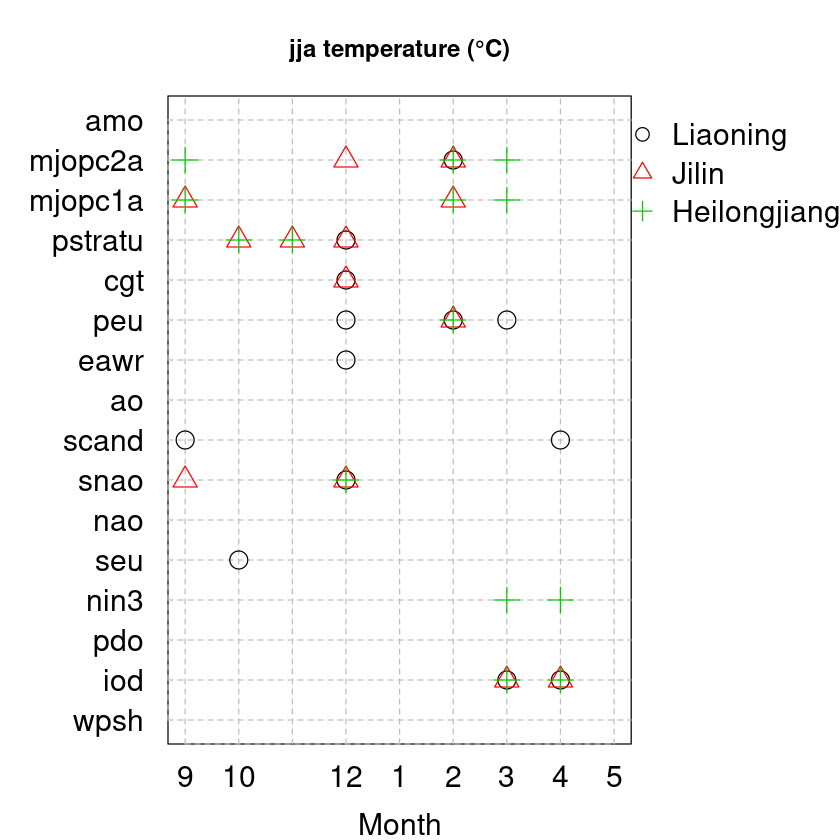

In [38]:
#png(paste('./', region,'_index_sig_mons_',num_vars,'_',ystrts,'_',yends,'_lag_',lag,'_',suffix,'.png', sep=""),width=10.25,height=12.25,units="in",res=300)
par(mfrow=c(1,1))
par(mar=c(4,7,4,8.7))
plot(NULL, xlim=c(1,length(mon_list)), ylim=c(1,length(ind_list)), ylab="", xlab="Month", 
     main = paste(suffix," temperature (\u00B0C)",sep=""), xaxt="n", yaxt="n", cex.lab=1.5)
#, xaxs="i", yaxs="i")
axis(1, at=1:length(mon_list), labels=mon_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5)
axis(2, at=1:length(ind_list), labels=ind_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5, las=1)

for (k in 1:1:length(regs)) {
    # for temperature 
    t_inds = which(abs(coef_array_full[k,2,sub]) > 0.5)
    tnames = strsplit(names(t_inds), split = "-")
    var_tind = numeric(0)
    mon_tind = numeric(0)
    
  
    ## match string to ind_list
    for (i in 1:length(t_inds)) {
    var_tind[i] = which(tnames[[i]][1] == ind_list)
    mon_tind[i] = which(as.numeric(tnames[[i]][2]) == mon_list)
    }
    points(mon_tind, var_tind, pch=k, col=k, cex=2)

}
legend("topright", legend = regs,bty = "n",
       pch = 1:length(regs), col=1:length(regs), 
       cex=1.5,xpd = TRUE, inset = c(-0.51, 0))

## Getting Jets

* Also do feature importance on the jets 

In [39]:
ndata = "/data/users/ncreaser/CSSP_china/data/Indices/"
j1u = "200hPa_uwind_box1_monthly_longer.csv"
#j1u = "300hPa_uwind_polar_monthly_longer.csv"
#  "200hPa_uwind_box1_monthly_longer.csv"
j1v = "200hPa_vwind_box1_monthly_longer.csv"
#j1v = "300hPa_vwind_polar_monthly_longer.csv"
  #"200hPa_vwind_box1_monthly_longer.csv"
j2u = "200hPa_uwind_box2_monthly_longer.csv"
#j2u ="300hPa_uwind_subtropical_monthly_longer.csv"
  #"200hPa_uwind_box2_monthly_longer.csv"
j2v = "200hPa_vwind_box2_monthly_longer.csv"
#j2v = "300hPa_vwind_subtropical_monthly_longer.csv" 
#  "200hPa_vwind_box2_monthly_longer.csv"

# read yield, T and P data
j1udat = read.csv(paste(ndata,j1u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j1vdat = read.csv(paste(ndata,j1v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

j2udat = read.csv(paste(ndata,j2u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j2vdat = read.csv(paste(ndata,j2v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

In [40]:
##### We havn't done anything with jets yet 
ystrt = 1981
yend = 2016
indyrsjet = which(j1udat[,1] == ystrt):which(j1udat[,1] == yend)

## calcaulte jja mean and de-trend
jmons = c("Mar", "Apr", "May", "Jun", "Jul", "Aug")
jmons_num = c(3,4,5,6,7,8)

j1ujja = j1udat[indyrsjet, jmons] 

colnames(j1ujja) = paste("eapju",jmons_num, sep="-")

j2ujja = j2udat[indyrsjet, jmons] 
colnames(j2ujja) = paste("easju",jmons_num, sep="-")

j1vjja = j1vdat[indyrsjet, jmons] 
colnames(j1vjja) = paste("eapjv",jmons_num, sep="-")

j2vjja = j2vdat[indyrsjet, jmons] 
colnames(j2vjja) = paste("easjv",jmons_num, sep="-")

jet_raw = as.matrix(cbind(j1ujja, j1vjja, j2ujja, j2vjja))

In [41]:
jet_df = array(NA, c(dim(jet_raw)[1], dim(jet_raw)[2]))
colnames(jet_df) = colnames(jet_raw)
rownames(jet_df) = rownames(cindex_df)

In [42]:
for (s in 1:dim(jet_raw)[2]) {
  # de-trend
  tt = 1:dim(jet_raw)[1]
  mod = lm(jet_raw[,s] ~ tt)
  jet_df[,s] = scale(mod$residual)
}

In [43]:
dx2 = 1+dim(jet_df)[2]

In [44]:
coef_jarray_full = array(0, c(length(regs),4,dx2))
dimnames(coef_jarray_full)[[3]] <- c("Intercept", colnames(jet_df))
dimnames(coef_jarray_full)[[1]] <- regs

[1] "Liaoning"
[1] "Selected temperature predictors"
[1] "eapju.4" "easju.8" "easjv.5"


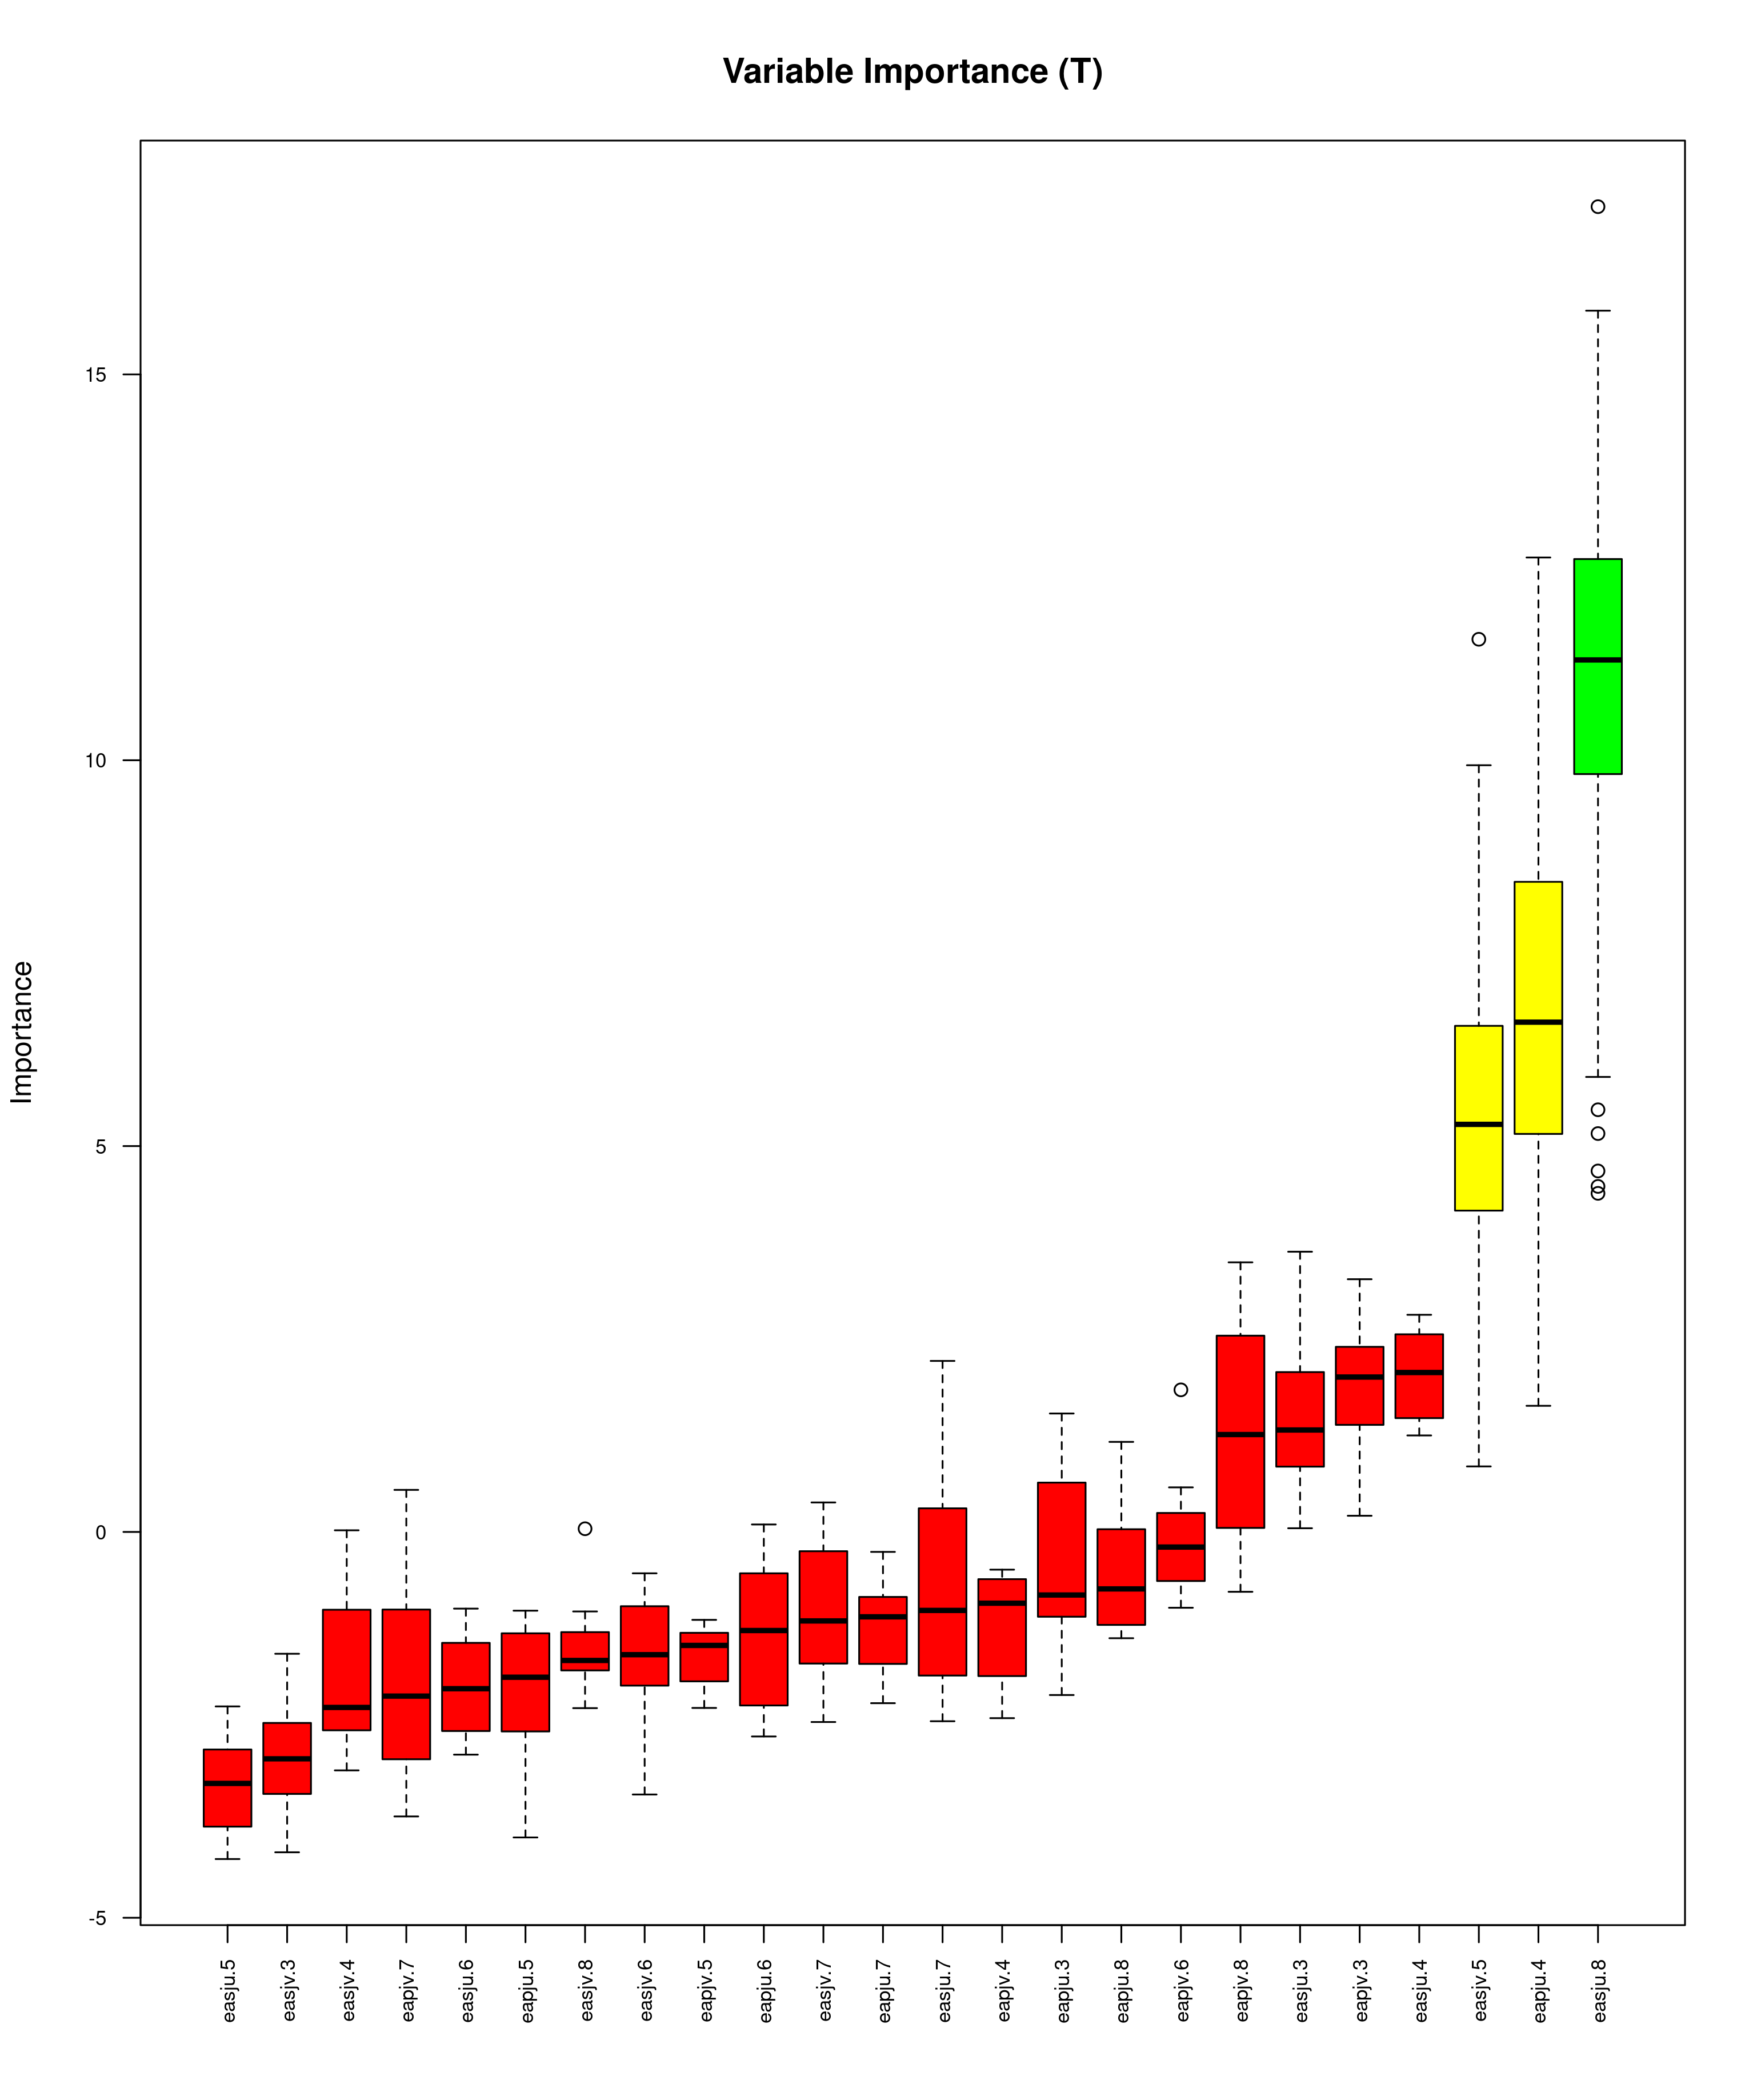

[1] "Jilin"
[1] "Selected temperature predictors"
[1] "eapju.4" "eapju.6" "eapjv.6" "easju.8" "easjv.5"


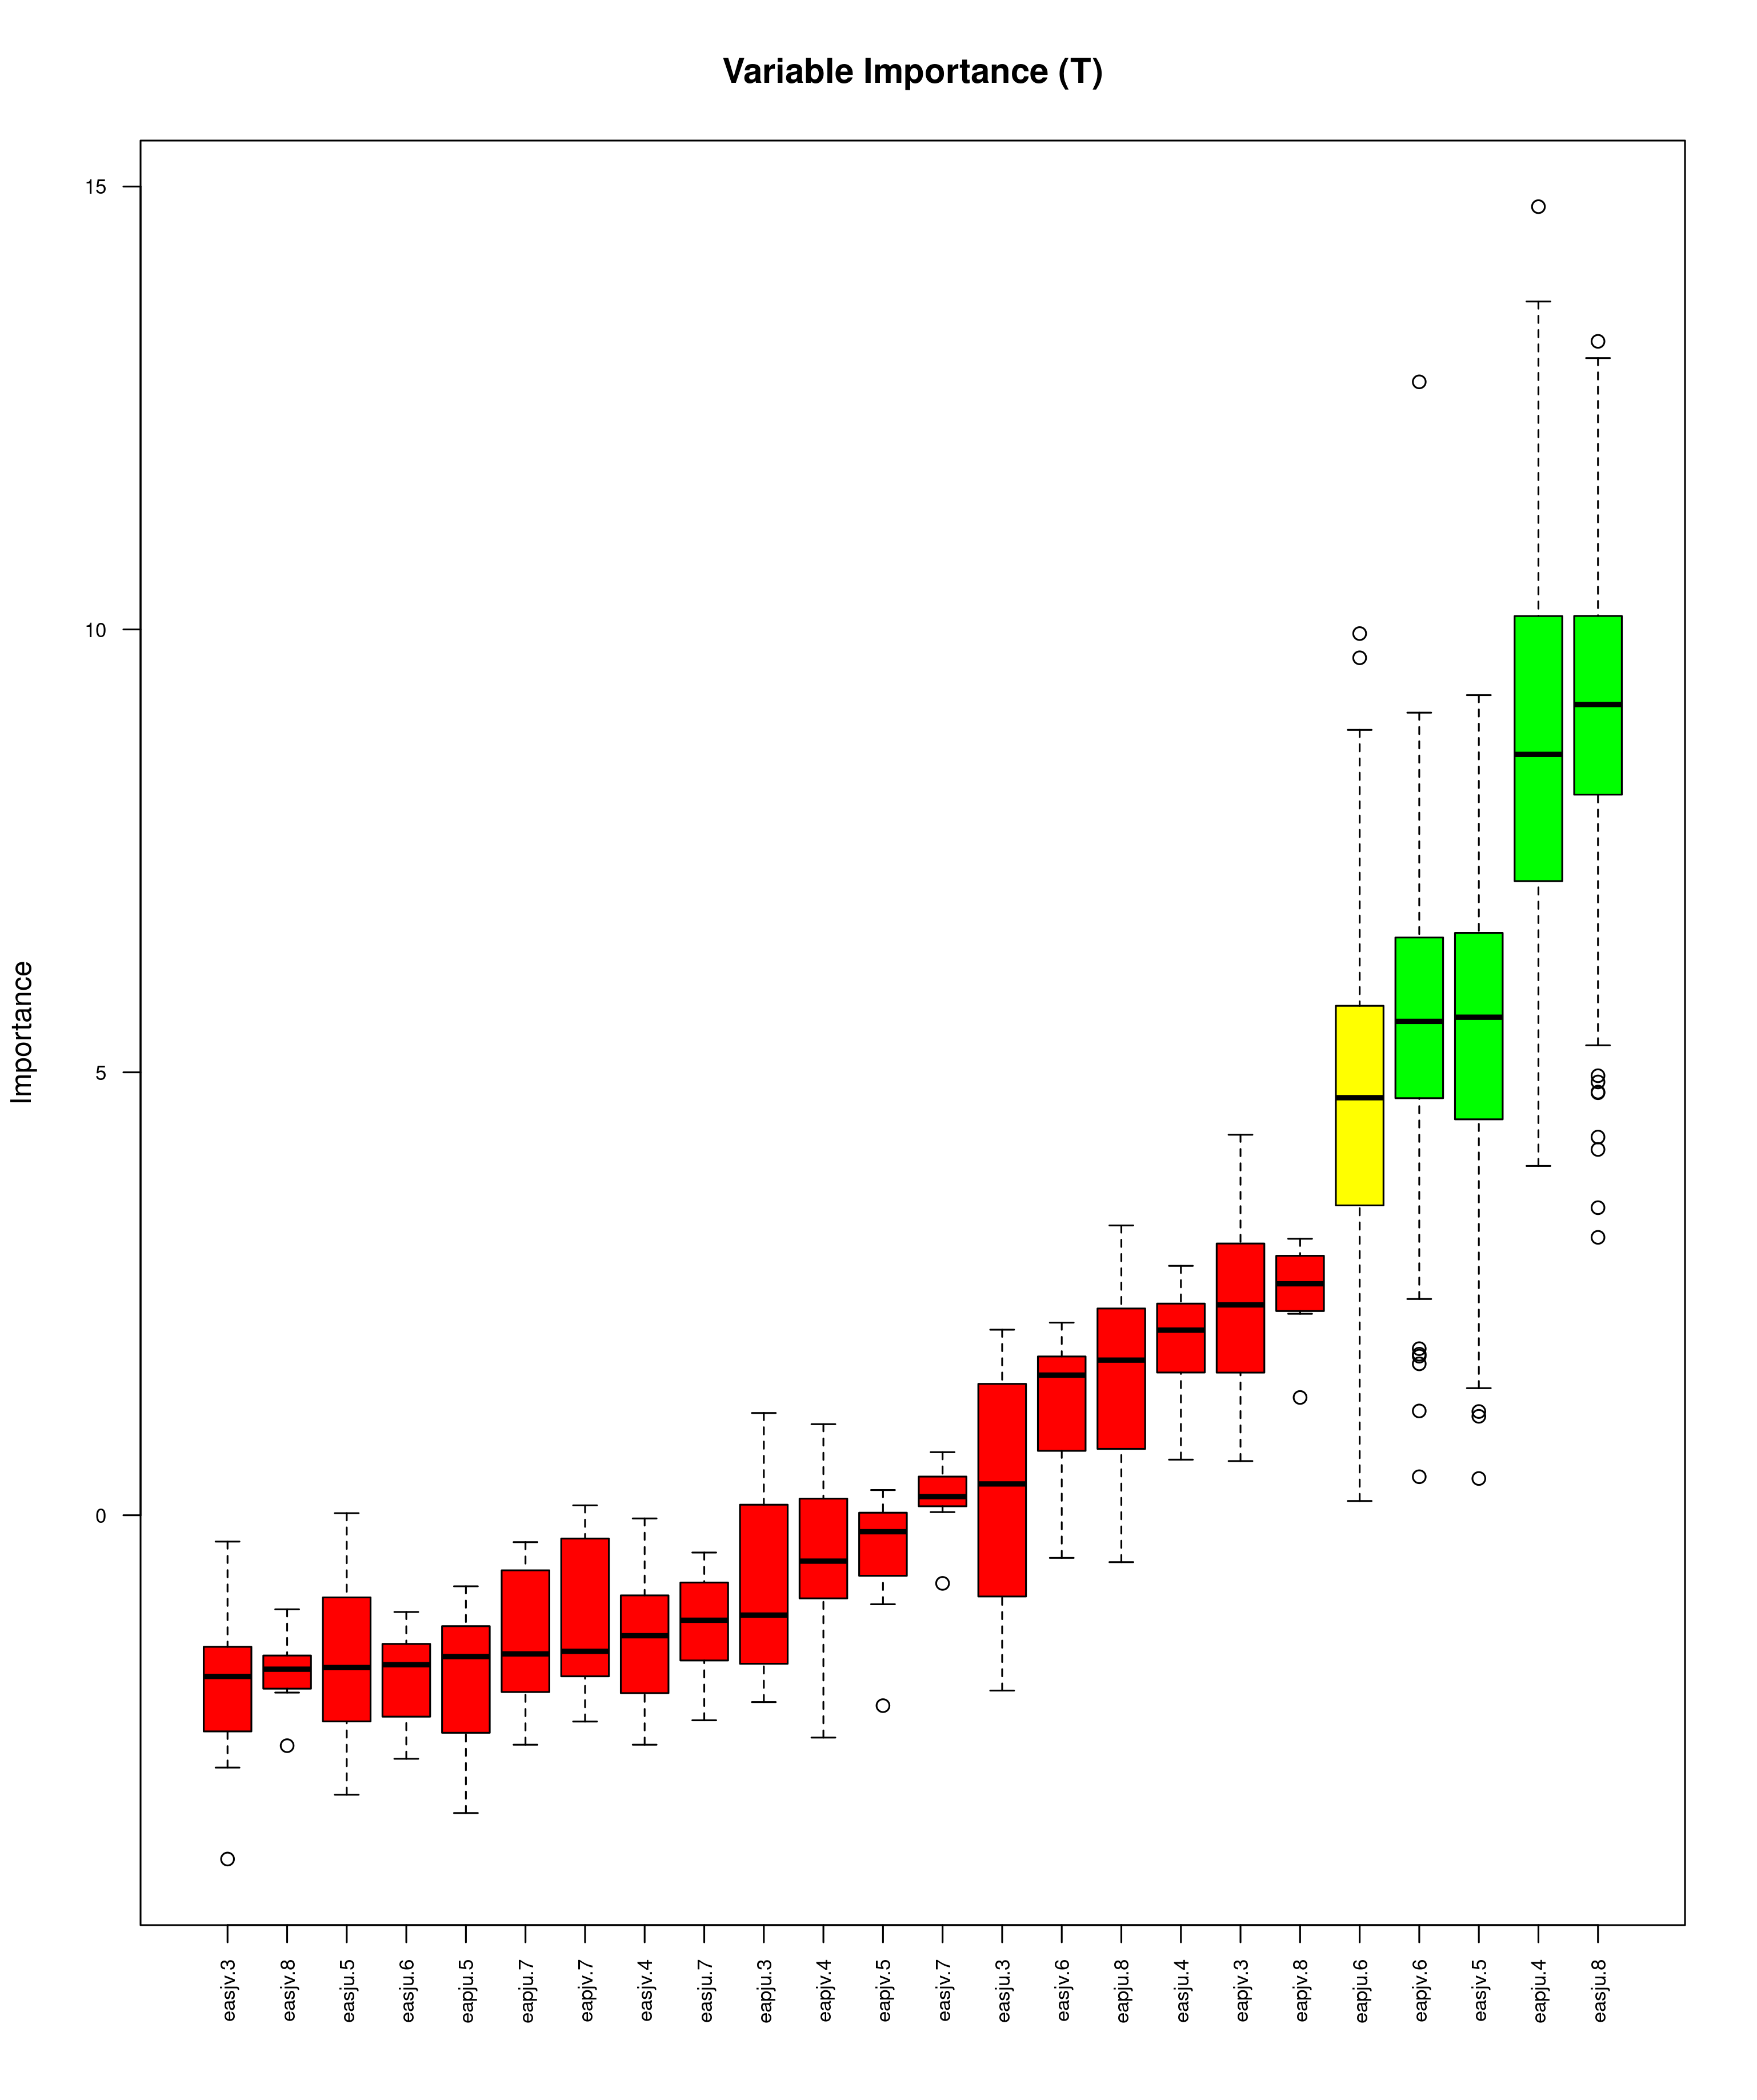

[1] "Heilongjiang"
[1] "Selected temperature predictors"
[1] "eapju.4" "eapju.6" "eapju.8" "eapjv.3" "easju.8" "easjv.6"


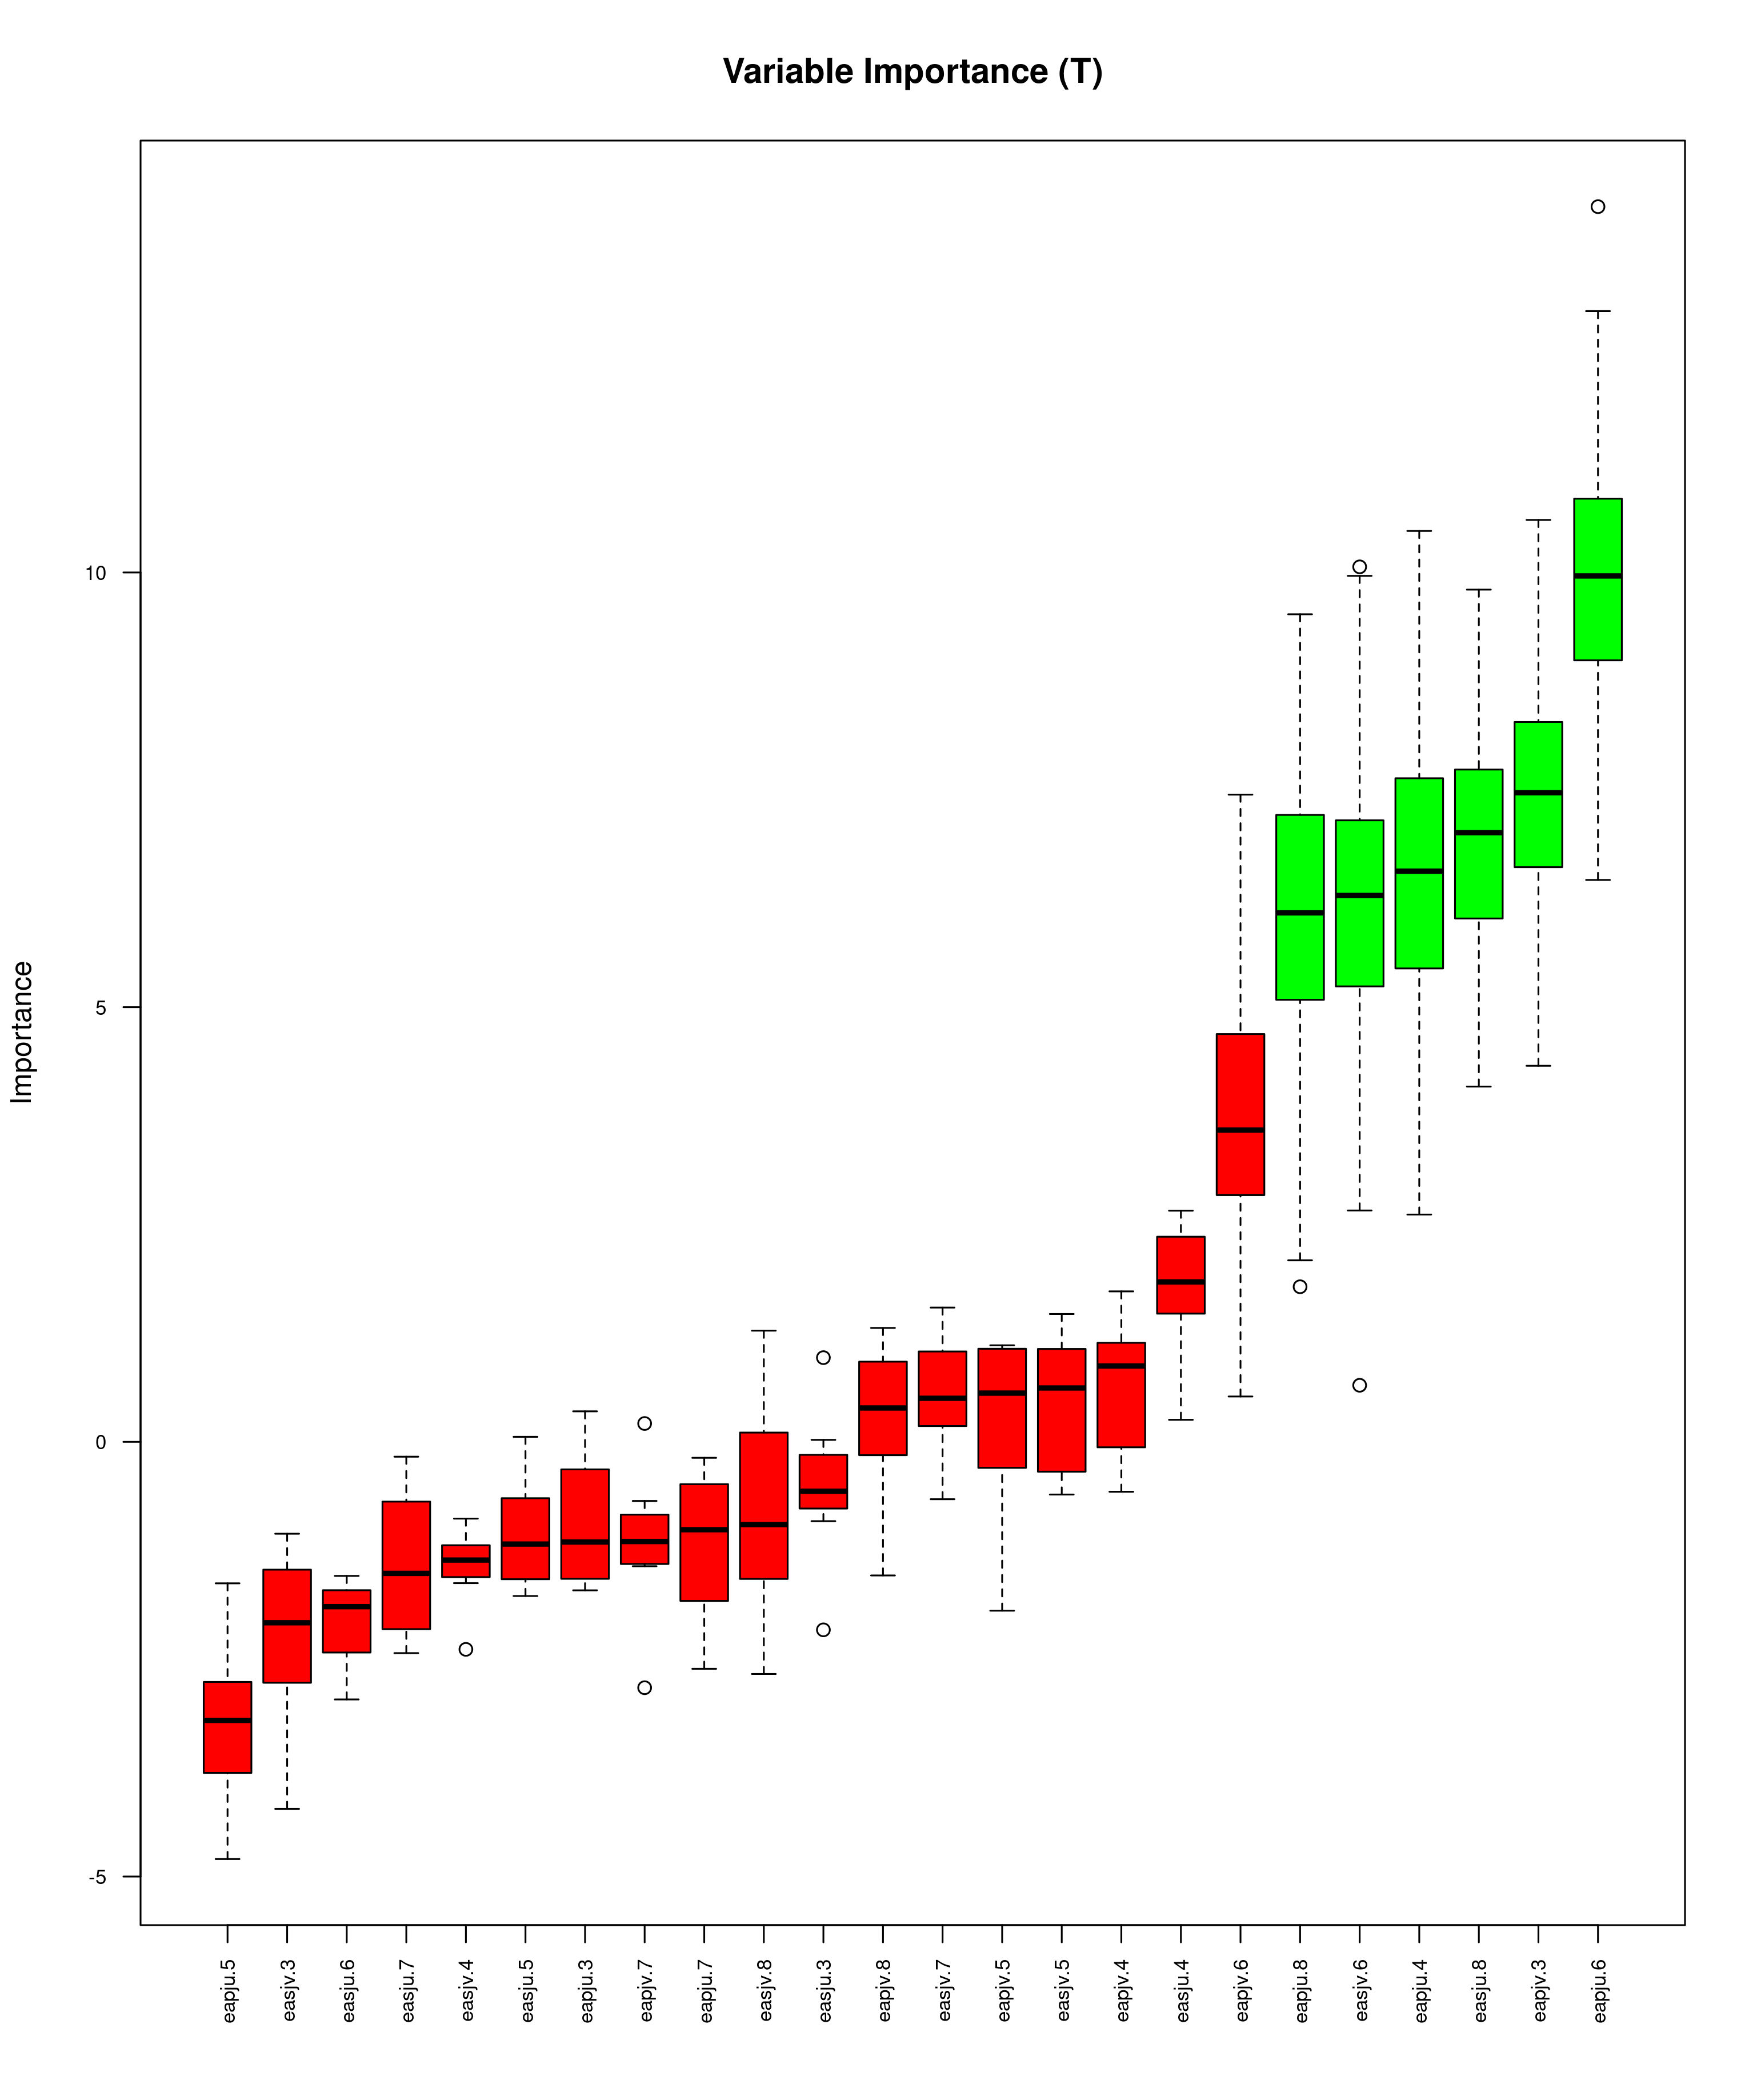

In [45]:
## do boruta on jet predicting t and P
for (k in 1:length(regs)) {
    print(regs[k])

    x_train = jet_df
    y_train = temp_anoms[,k]

    din1  = data.frame(cbind(x_train, y_train))
    boruta_output1 <- Boruta(y_train ~ ., data=din1, doTrace=0, maxRuns= 200, ntree=2000, pValue = 0.1)  # perform Boruta search

    boruta_signif1 <- names(boruta_output1$finalDecision[boruta_output1$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
    print("Selected temperature predictors")
    print(boruta_signif1) 

    ## remove shadows from plot
    png(paste('./china_maize_jet_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep=""),width=10.25,height=12.25,units="in",res=300)
    plot(boruta_output1, cex.axis=.7, las=2, xlab="", main="Variable Importance (T)", whichShadow = c(FALSE, FALSE, FALSE))  # plot variable importance
    dev.off()
    display_png(file=paste('./china_maize_jet_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")) 

    tvars = gsub("[[:punct:]]", "-", boruta_signif1)

    coef_jarray_full[k,2,tvars] = 1

}


# Create Bayesian Network  

In [46]:
library(bnlearn)
library(igraph)



Attaching package: 'igraph'


The following objects are masked from 'package:bnlearn':

    as.igraph, compare, degree, subgraph


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [56]:
get_blacklist <- function(mat, eff_cols, monlist) {
# mat is a data matrix containing causes and effects
# eff_cols are the columns for the effects
##   
  # create a list of forbidden links, i.e. non-causal links
  # prevent regions from predicting each other and effects resulting in causes.
neffs = length(eff_cols)  
# split the names
tns = strsplit(colnames(mat), ".", fixed = TRUE)
# put in a matrix
tnsmat = matrix(unlist(tns),ncol=2,byrow=T)

# order the months
from_mons = numeric(0)   
for (i in 1:(dim(mat)[2]-neffs)) {
  #     print(i)
  from_mons[i] = which(as.numeric(tnsmat[i,2]) == monlist)
}

# find which links would be backwards in time
from_to = numeric(0)
for (i in 1:length(from_mons)) {
  to_mons = which(from_mons < from_mons[i])
  from_names = rep(colnames(mat)[i], times=length(to_mons))
  to_names = colnames(mat)[to_mons]
  from_to_new = cbind(from_names, to_names)
# now add to "from_to"  
  from_to = rbind(from_to, from_to_new)
}
    
# make sure each effect can't cause anything, repeat over all effect columns
#from_names = rep(colnames(mat)[dim(mat)[2]], times=(dim(mat)[2]-neffs))
#to_names = colnames(mat)[1:(dim(mat)[2]-neffs)]
for (k in 1:neffs) {
  # get the name of the effect, and repeat by the number of columns - 1 (i.e. from itself to every other column)
  from_names = rep(colnames(mat)[eff_cols[k]], times=(dim(mat)[2]-1))
  # link to all other columns (just drop the current col name)
  to_names = colnames(mat)[-eff_cols[k]]
  from_to_new = cbind(from_names, to_names)
## Add to "from to"
  from_to = rbind(from_to, from_to_new)
}

# return th list
return(from_to) 
}

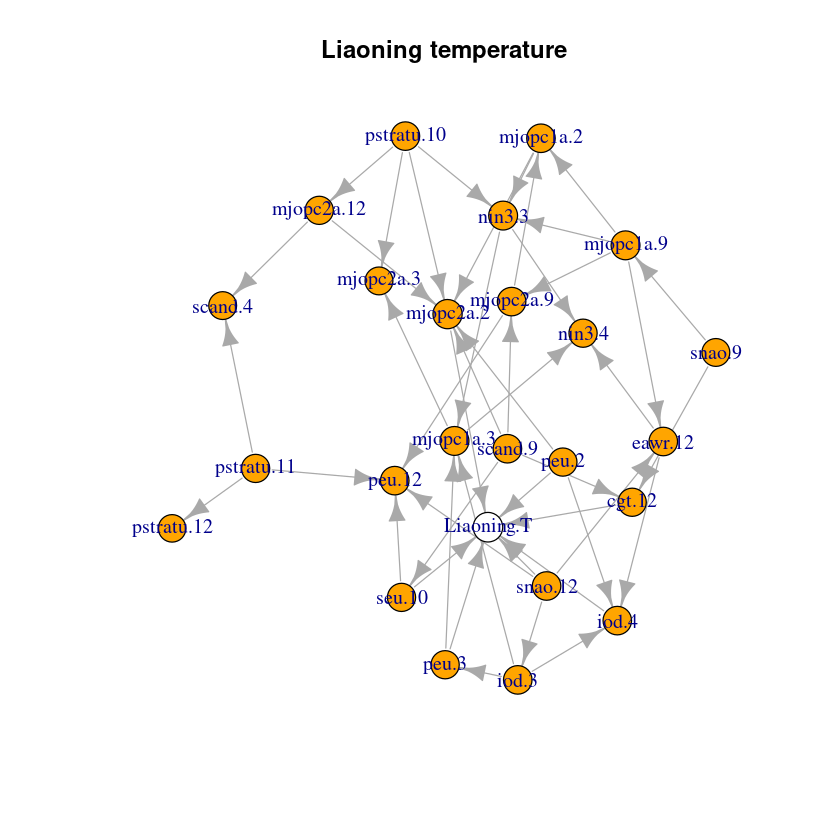

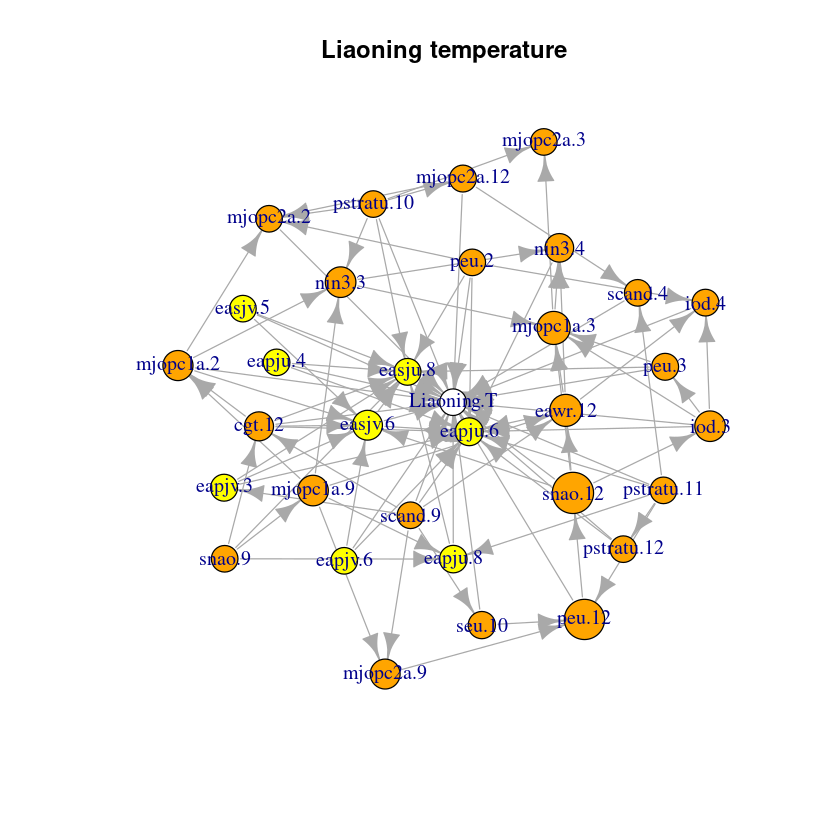

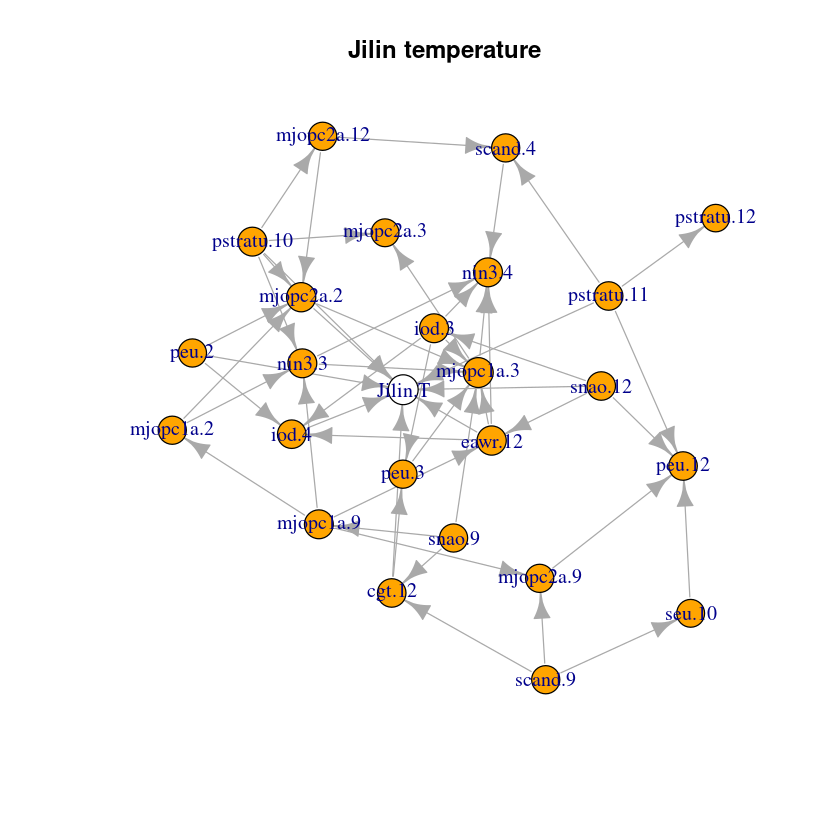

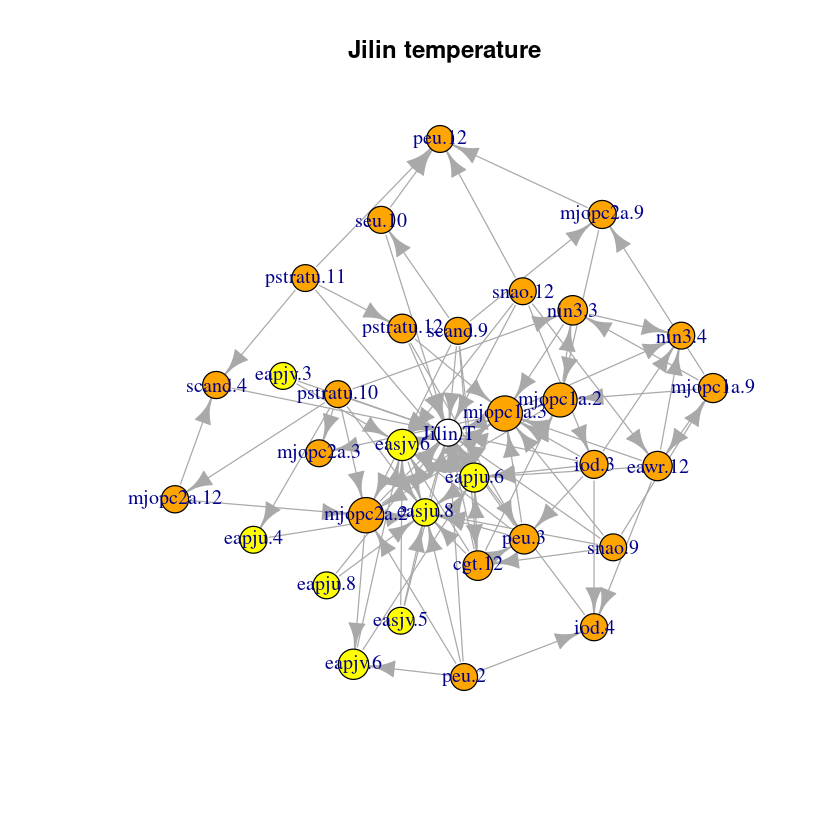

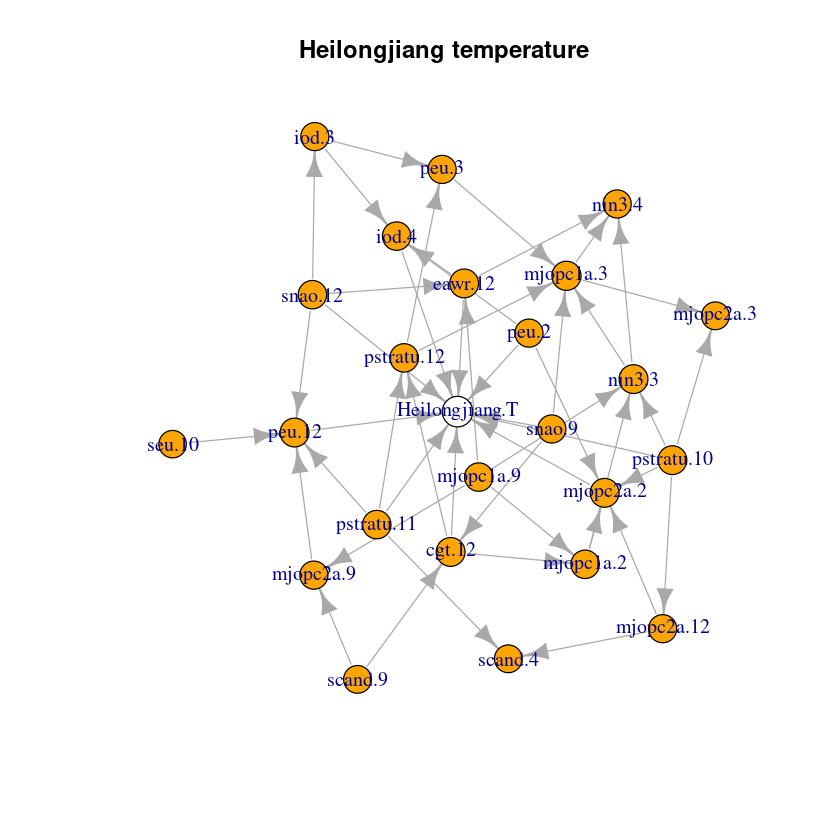

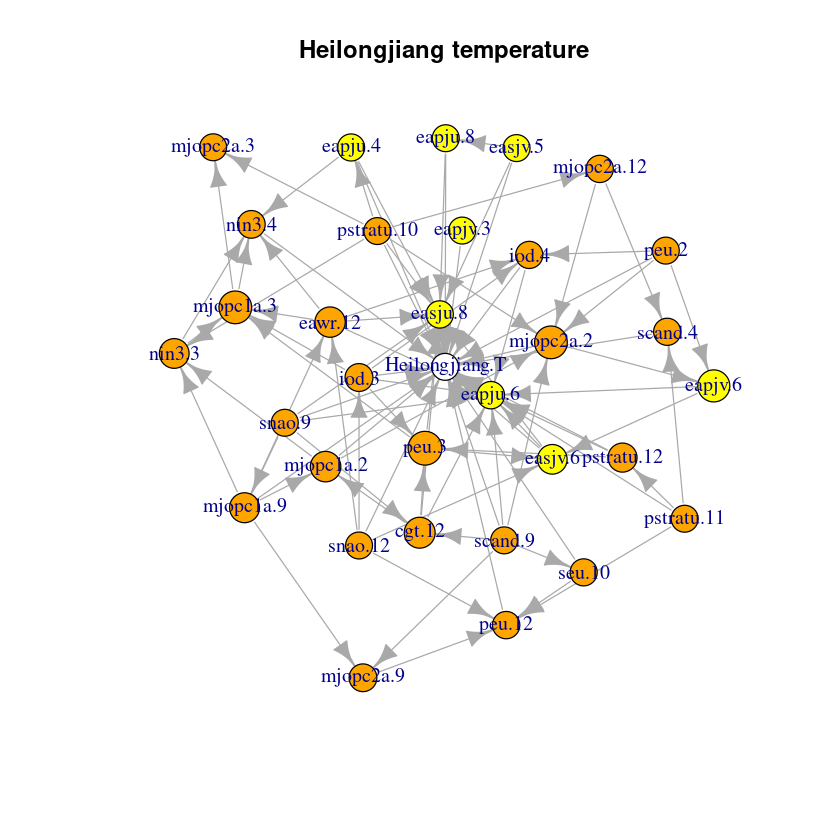

In [64]:
for (k in 1:length(regs)) {
  tmat = data.frame(cindex_df[,inds_all], temp_anoms[,k, drop=F])
  # get blacklist
  eff_cols = length(colnames(tmat))
  tbl = get_blacklist(tmat, eff_cols, mon_list)
  # learn network structure   
  g = averaged.network(boot.strength(tmat, R = 100, algorithm = "hc",algorithm.args = list(blacklist = tbl)))
    #hc(tmat, blacklist = tbl)
  # fit Bayesian network    
  gbn = bn.fit(g, tmat)
  # evaluate the network for forecasting Temperature: lower values of the loss are better. Currently using MSE
  tvarname = colnames(tmat)[length(colnames(tmat))]
  t_loss[k] = mean(loss(bn.cv(tmat, bn="hc", method="k-fold", k=10, runs=10, loss="cor-lw", loss.args=list(target=tvarname))))
  # store the network
  tbn_all[[k]] = gbn
  # store the parents
  t_parent[[k]] = parents(gbn, tvarname)
  # store as igraph object    
  gg = as.igraph(g)
  # simplify - probably not necessary    
  gg2 = simplify(gg)
  # identify and remove any isolated vertices
  isolated = which(degree(gg2)==0)
  gg3 = delete.vertices(gg2, isolated)
  # set layout rules    
  l = layout_with_gem(gg3)
  colst = c(rep("Orange", times = (length(inds_all)-length(isolated))), rep("white", times=1))
  shapesl = c("circle", "square", "csquare", "rectangle", "crectangle", "vrectangle")
  varname = paste(regs[k]," temperature", sep="")
  vname = paste(regs[k],"_temperature", sep="")
  #png(paste('/net/home/h06/epope/climate_security/python_code/HCCP/china_maize_network_',vname,'_',num_vars,'_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""), width=10.25,height=12.25,units="in",res=400)
  plot(gg3, layout=l, vertex.size = 10.0+(degree(gg3)/8.0), vertex.color = colst, cex=4, main=varname, resolution=2)
  #vertex.color=rainbow(3, alpha=0.6)[clusterlouvain$membership], main=varname, resolution=2)
  #dev.off()
  
  # generate the network including jets 
  tmat2 = data.frame(cindex_df[,inds_all], jet_df[,jinds_all], temp_anoms[,k, drop=F])
  all_mon_list = unique(c(mon_list, jmons_num))
  eff_cols = length(colnames(tmat2))
  tbl2 = get_blacklist(tmat2, eff_cols, all_mon_list)
  ga = averaged.network(boot.strength(tmat2, R = 100, algorithm = "hc",algorithm.args = list(blacklist = tbl2)))
    #hc(tmat2, blacklist = tbl2)
  gbna = bn.fit(ga, tmat2)
  gga = as.igraph(ga)
  gg2a = simplify(gga)
  isolateda = which(degree(gg2a)==0)
  gg3a = delete.vertices(gg2a, isolateda)
  la = layout_with_gem(gg3a)
  # Get names
  tnetworknames = gsub("[[:punct:]]", "-", names(degree(gg3a)))
  #  pallnames = gsub("[[:punct:]]", "-", colnames(pmat2))
  tclim_inds = match(colnames(cindex_df)[inds_all], tnetworknames)
  tjet_inds = match(colnames(jet_df)[jinds_all], tnetworknames)
  colst = c(rep("Orange", times = length(tclim_inds[is.finite(tclim_inds)])), rep("Yellow", times = length(tjet_inds[is.finite(tjet_inds)])), rep("white", times=1))
#  colst = c(rep("Orange", times = (length(t_inds_all)+length(tj_inds_all)-length(isolateda))), rep("white", times=1))
  shapesl = c("circle", "square", "csquare", "rectangle", "crectangle", "vrectangle")
  varname = paste(regs[k]," temperature", sep="")
  vname = paste(regs[k],"_temperature", sep="")
  #png(paste('/net/home/h06/epope/climate_security/python_code/HCCP/china_maize_network_',vname,'_jet_',num_vars,'_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""), width=10.25,height=12.25,units="in",res=400)
  plot(gg3a, layout=la, vertex.size = 10.0+(betweenness(gg3a)/8.0), vertex.color = colst, cex=4, main=varname, resolution=2)
  #vertex.color=rainbow(3, alpha=0.6)[clusterlouvain$membership], main=varname, resolution=2)
  #dev.off()
}

# Section 5: Predictive models 

In [333]:
for (k in 1:length(regs)) {
    # get the T and P indexs of significant varibles 
    t_inds = which(abs(coef_array_full[k,2,sub]) > 0.5)
    p_inds = which(abs(coef_array_full[k,3,sub]) > 0.5)
    
    for (y in 1:length(years)) {
        #print(y)
        rind = y
        tt = 1:length(temp_jja[-rind,k]) # TO DO isnt this just always 1:35 ? 
        lmmodt = lm(temp_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
        lmmodp = lm(precip_jja[-rind,k] ~ tt)

        # get mean T/P for the missing year    
        ttout_of_sample_data <- data.frame(tt = t(rind))
        tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit
        pmean_pred = predict(lmmodp, ttout_of_sample_data, se.fit = TRUE)$fit
        
        
        if (length(t_inds) > 0) {
            tmod = automate_predict("t", lmmodt$residuals, cindex_df[-rind,t_inds], cindex_df[rind,t_inds])
            tmod_fit = tmod$model$fitted.values
            t_loocv[y,k] = tmod$pred
            t_effcv[y,k,t_inds] = tmod$effects
            t_int[y,k] = tmod$model$coefficients[1]
            frac = abs(t_effcv[y,k,t_inds])/sum(abs(t_effcv[y,k,t_inds]))
            t_ent[y,k] = -1.0*sum(frac*log(frac))

            ## forecast using random forests      
            set.seed(2019)
            # fit the model
            if (length(t_inds) > 1) {
                fit_rft <- randomForest(x=cindex_df[-rind,t_inds], y=lmmodt$residuals)
                t_loocv_rf[y,k] <- predict(fit_rft, cindex_df[rind,t_inds])
            } else {
                t_loocv_rf[y,k] <- 0.0
            }
        }
        
        if (length(p_inds) > 0) {
            pmod = automate_predict("p", lmmodp$residuals, cindex_df[-rind,p_inds], cindex_df[rind,p_inds])
            pmod_fit = pmod$model$fitted.values
            p_loocv[y,k] = pmod$pred
            p_effcv[y,k,p_inds] = pmod$effects
            p_int[y,k] = pmod$model$coefficients[1]
            ## calculate entropy each year
            frac = abs(p_effcv[y,k,p_inds])/sum(abs(p_effcv[y,k,p_inds]))
            p_ent[y,k] = -1.0*sum(frac*log(frac))

            if (length(p_inds) > 1) {
                fit_rfp <- randomForest(x=cindex_df[-rind,p_inds], y=lmmodp$residuals)
                p_loocv_rf[y,k] <- predict(fit_rfp, cindex_df[rind,p_inds])
            } else {
                p_loocv_rf[y,k] <- 0.0
            }
        }
        
        t_train = lmmodt$fitted.values + tmod_fit
        p_train = lmmodp$fitted.values + pmod_fit

        t_oos = tmean_pred + tmod$pred
        p_oos = pmean_pred + pmod$pred

        t_oos_rf = tmean_pred + t_loocv_rf[y,k]
        p_oos_rf = pmean_pred + p_loocv_rf[y,k]

        ## also save out absolute temp and rainfall      
        p_abs_loocv[y,k] = p_oos
        t_abs_loocv[y,k] = t_oos

        p_abs_loocv_rf[y,k] = p_oos_rf
        t_abs_loocv_rf[y,k] = t_oos_rf
    
    }
}

In [339]:
t_loocv[,1]

1981        1982        1983        1984        1985        1986 
 0.25388017  0.62830946  0.06265344  0.03395706  0.30353240 -0.27411805 
       1987        1988        1989        1990        1991        1992 
-0.21737621  0.32390456 -0.55438676 -0.41818432 -0.04778480 -0.75842419 
       1993        1994        1995        1996        1997        1998 
-0.83307347  0.89199415  0.08526245 -1.03130872  0.85083750 -0.39409629 
       1999        2000        2001        2002        2003        2004 
 0.78553208  1.56379870  1.03108759 -0.46152433  0.00327252 -0.07974491 
       2005        2006        2007        2008        2009        2010 
-0.42069023 -0.07996148  0.26773680 -0.98091791 -0.07227975  0.11018656 
       2011        2012        2013        2014        2015        2016 
 0.22486547 -0.29912314  0.26596298  0.14464704 -0.40695625  0.38882165

In [335]:
head(t_loocv)

,Liaoning,Jilin,Heilongjiang
1981,0.25388017,0.3951817,0.08702767
1982,0.62830946,0.8868140,0.89460914
1983,0.06265344,-0.6280296,-0.53697772
1984,0.03395706,0.3239236,0.61482813
1985,0.30353240,0.6202524,0.78637240
1986,-0.27411805,-0.3382693,-0.12435317


In [341]:
cor(t_loocv[, 1], temp_anoms[,1])

[1] 0.8358835

In [336]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
0.4767537,-0.07799843,-0.53412111
1.0461054,1.81619148,2.06508026
-0.1926158,-1.65087332,-2.06402876
0.3694542,0.28934417,-0.02428095
-0.1619110,0.11110493,0.11437196
-1.1381192,-0.94495550,-0.37800865


### Creating stacked plots 

In [181]:
create_df<-function(ind_effect, obs, yrs, monlist, indlist){
    v_inds = which(ind_effect[1,] != 0)
    vnames2 = names(v_inds)
    tt = 1:length(obs)
    lmmod = lm(obs ~ tt)
    year <- rep(yrs, each=length(v_inds))
    index <- rep(vnames2, times=length(yrs))
    value <- as.vector(t(ind_effect[,v_inds]))
    data <- data.frame(year,index,value)
    obs_resids = as.vector(lmmod$residuals)
    d2 <-data.frame(years, obs_resids)
    df <- data.frame(data)
    df$bar_heights <- rep(tapply(data$value, data$year, sum), each=length(v_inds))
    df$line_y <- rep(obs_resids,each=length(v_inds))

    return(df)
}

In [224]:
for (k in 1:length(regs)) {
    df_temp = create_df(t_effcv[,k,], temp_anoms[,k], rownames(temp_jja), mon_list, ind_list)
    df_precip = create_df(p_effcv[,k,], precip_anoms[,k], rownames(temp_jja), mon_list, ind_list)
  # Stacked
  #  dev.new()
    p <- ggplot(df_temp, aes(fill=index, y=value, x=year)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
        theme(axis.text.x = element_text(angle = 90)) +
        theme(text = element_text(size=14))
    #p  + 
        #geom_line(aes(x=year, y=line_y), colour = "black") + 
        #geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(p)
 #   p  + theme(text = element_text(size=20))
    #ggsave(paste("./", region,"_temp_stacked_",num_vars,'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,'_',suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
    q <- ggplot(df_precip, aes(fill=index, y=value, x=year)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," precipitation (mm)", sep="")) + 
        theme(axis.text.x = element_text(angle = 90)) + 
        theme(text = element_text(size=14))
    q + geom_line(aes(x=year, y=line_y), colour = "black") + 
        geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(q)
    #ggsave(paste("./", region,"_precip_stacked_",num_vars,'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,"_",suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
}

ERROR: Error in which(ind_effect[1, ] != 0): object 't_effcv' not found


# Producing Linear Model with subset of predictors 

In [193]:
t_loocv_red = create_empty_dataframe(rownames(temp_jja), regs)
p_loocv_red = create_empty_dataframe(rownames(temp_jja), regs)

t_effcv_red = array(NA, c(length(years),length(regs), dim(cindex_df)[2]))
p_effcv_red = array(NA, c(length(years),length(regs), dim(cindex_df)[2]))
dimnames(t_effcv_red)[[3]] <- colnames(cindex_df)
dimnames(p_effcv_red)[[3]] <- colnames(cindex_df)

In [194]:
dim(cindex_df)[2]

[1] 144

In [195]:
for (k in 1:length(regs)) {
    # get the T and P indexs of significant varibles 
    
    t_inds_red = gsub("[[:punct:]]", "-", t_parent[[k]])
    p_inds_red = gsub("[[:punct:]]", "-", p_parent[[k]])
    
    for (y in 1:length(years)) {
        #print(y)
        rind = y
        tt = 1:length(temp_jja[-rind,k]) # TO DO isnt this just always 1:35 ? 
        lmmodt = lm(temp_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
        lmmodp = lm(precip_jja[-rind,k] ~ tt)

        # get mean T/P for the missing year    
        ttout_of_sample_data <- data.frame(tt = t(rind))
        tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit
        pmean_pred = predict(lmmodp, ttout_of_sample_data, se.fit = TRUE)$fit
        
        
        if (length(t_inds_red) > 0) {
            tmod = automate_predict("t", lmmodt$residuals, cindex_df[-rind,t_inds_red], cindex_df[rind,t_inds_red])
            tmod_fit = tmod$model$fitted.values
            t_loocv_red[y,k] = tmod$pred
            t_effcv_red[y,k,t_inds_red] = tmod$effects

        }
        
        if (length(p_inds_red) > 0) {
            pmod = automate_predict("p", lmmodp$residuals, cindex_df[-rind,p_inds_red], cindex_df[rind,p_inds_red])
            pmod_fit = pmod$model$fitted.values
            p_loocv_red[y,k] = pmod$pred
            p_effcv_red[y,k,p_inds_red] = pmod$effects

        }
    
    }
}

In [196]:
cor(t_loocv_red[, 1], temp_anoms[,1])

[1] 0.8710891

In [197]:
p_inds_red

[1] "wpsh-3" "peu-9"

In [221]:
cor(p_loocv_red[, 3], precip_anoms[,3])

[1] 0.4705888

In [241]:
typeof(df_temp$line_y)

[1] "double"

In [238]:
typeof(df_temp$year)

[1] "integer"

In [242]:
df_temp$year <- as.numeric(df_temp$year)

In [240]:
df_temp$line_y <- as.numeric(df_temp$line_y)

In [251]:
z = geom_line(data=df_temp, aes(x=year, y=line_y), colour = "black")

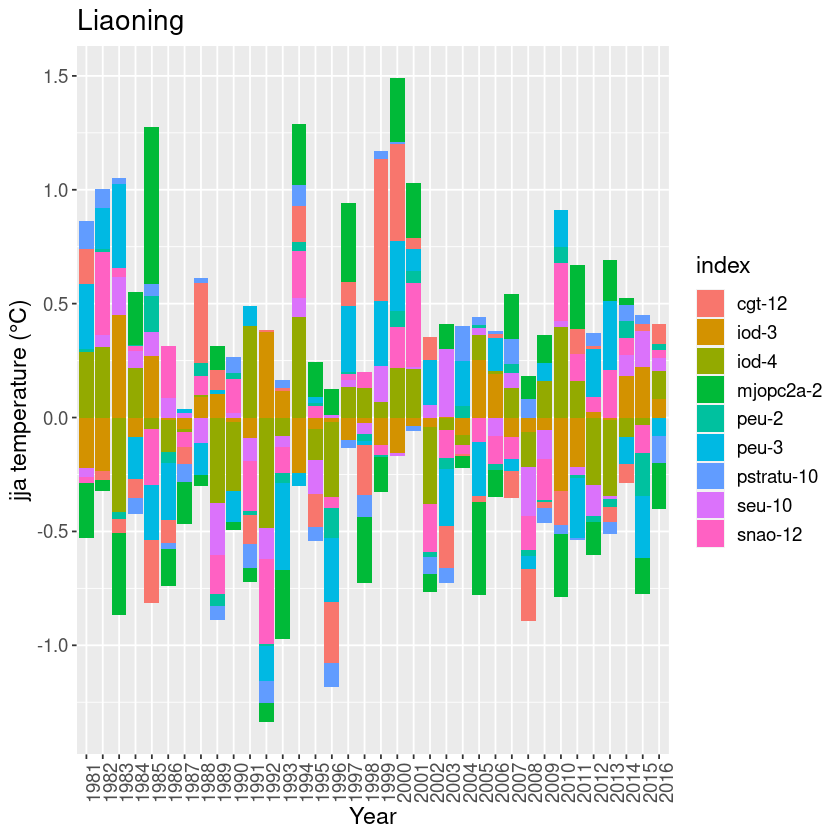

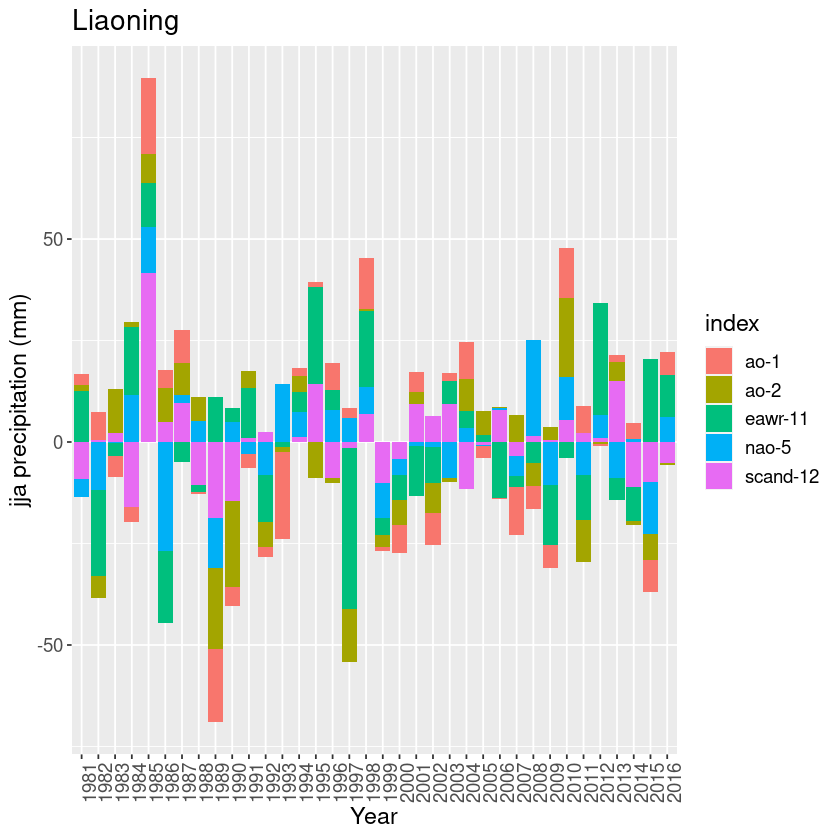

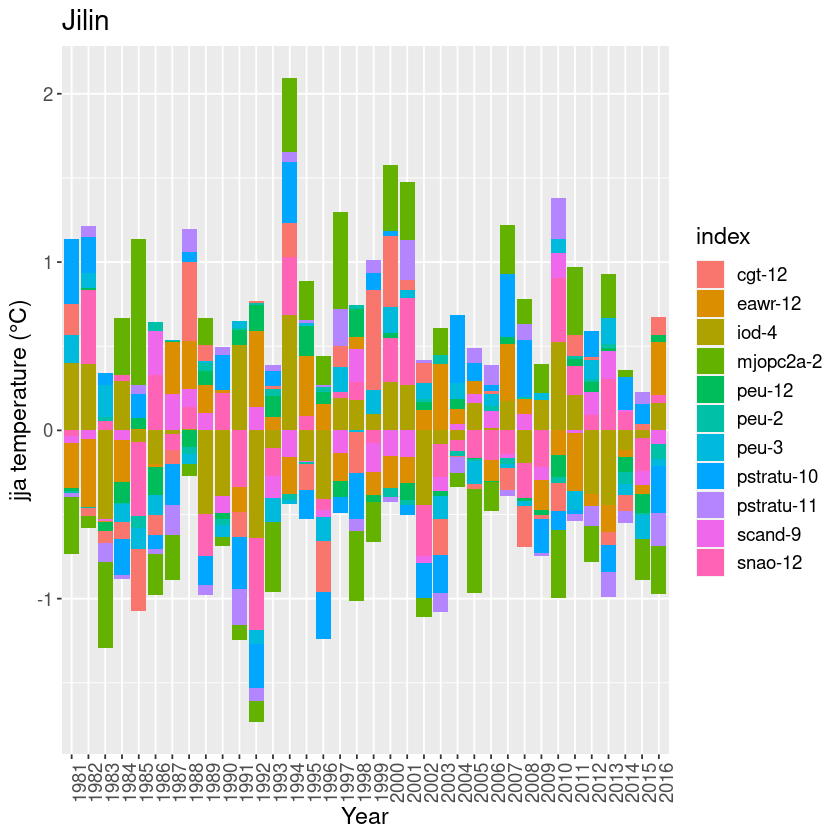

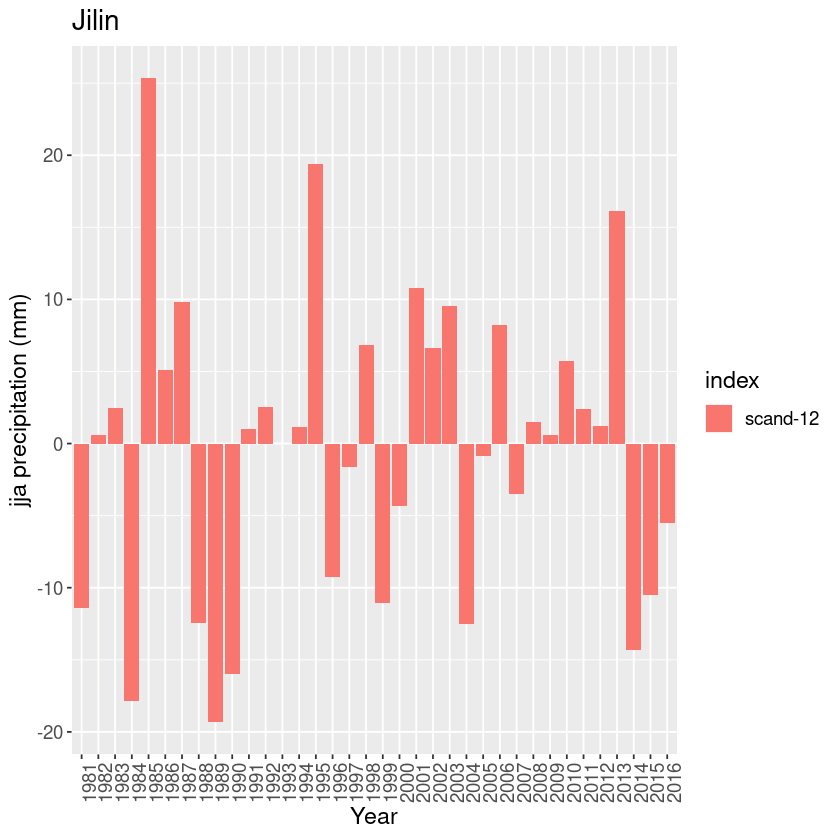

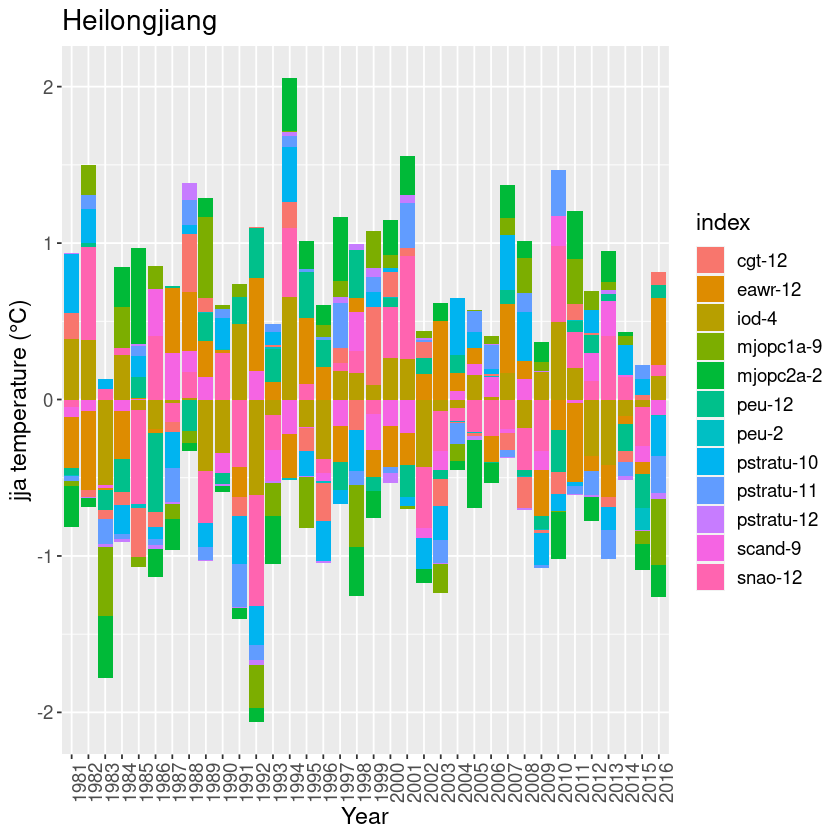

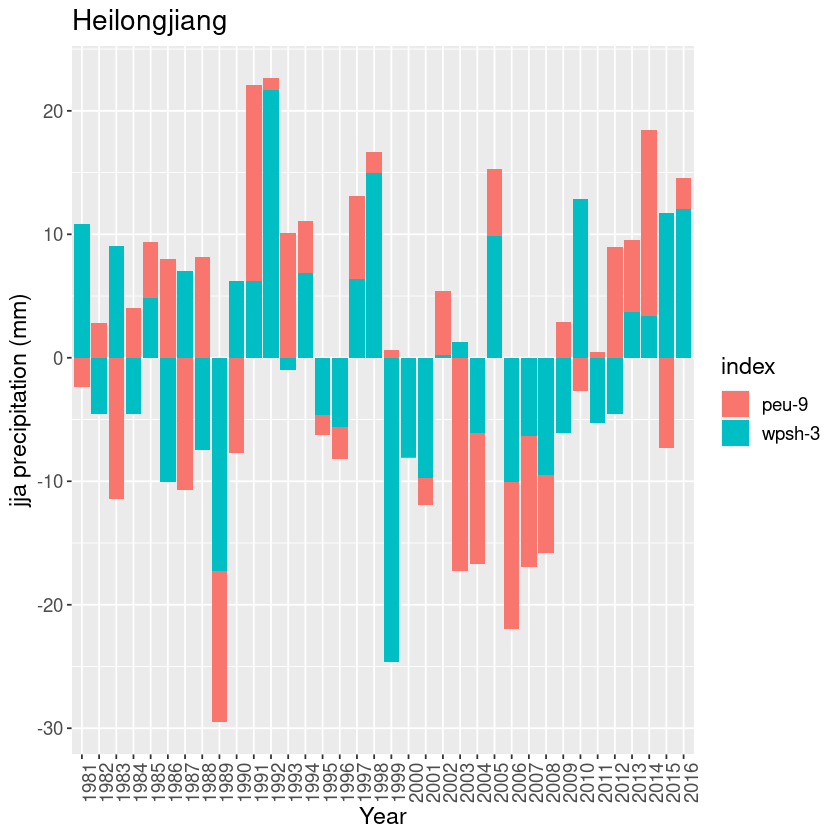

In [257]:
for (k in 1:length(regs)) {
    df_temp = create_df(t_effcv_red[,k,], temp_anoms[,k], rownames(temp_jja), mon_list, ind_list)
    df_precip = create_df(p_effcv_red[,k,], precip_anoms[,k], rownames(temp_jja), mon_list, ind_list)
  # Stacked
  #  dev.new()
    p <- ggplot(df_temp, aes(fill=index, y=value, x=year, group=1)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
        theme(axis.text.x = element_text(angle = 90)) +
        theme(text = element_text(size=14)) 
    p + 
        geom_line(aes(x=year, y=line_y), colour = "black") + 
        geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(p)
    p  + theme(text = element_text(size=20))
    #ggsave(paste("./", region,"_temp_stacked_",'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,'_',suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
    q <- ggplot(df_precip, aes(fill=index, y=value, x=year)) + 
        geom_bar(position="stack", stat="identity") + 
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," precipitation (mm)", sep="")) + 
        theme(axis.text.x = element_text(angle = 90)) + 
        theme(text = element_text(size=14))
    q + geom_line(aes(x=year, y=line_y), colour = "black") + 
        geom_line(aes(x=year, y=bar_heights), colour = "red")
    print(q)
    #ggsave(paste("./", region,"_precip_stacked_",num_vars,'_',ystrts,'_',yends,"_",regs[k],"_lag_",lag,"_",suffix,".png", sep=""), width = 9, height = 5, dpi = 400, units = "in")
    
}

## Calculating skill at different lead time 

In [202]:
sort_df_cols_on_month <- function(dataframe, months) {
    
    tns = strsplit(colnames(dataframe), "-", fixed = TRUE) # split column names into name and month 
    
    tnsmat = matrix(unlist(tns),ncol=2,byrow=T) # put into seperate columns 
    
    # make an order for these months based on our months we provide to the function 
    from_mons = numeric(0)   
    for (i in 1:(dim(dataframe)[2])) {
      #     print(i)
      from_mons[i] = which(as.numeric(tnsmat[i,2]) == months)
    }
    
    # combine from_mons into our columns of var name and month 
    data = cbind(from_mons, tnsmat) 
    # now we order all the columns based on from_mons, to get the correct order 
    data_final=data[order(data[ , 1]), ]
    # now we need to combine our correctly sorted months into column header format of our orginal dataframe
    new_heading_order = paste(data_final[, 2], data_final[, 3], sep = "-")
    
    # finally we can return our sorted dataframe 
    return(dataframe[, new_heading_order])
}
    
automate_predict_new_test <- function(namex, ydata, xdata, xoos) {
  #    browser()
  xmat = as.matrix(xdata)
  df = data.frame(ydata, xdata)
  colnames(df) = c("Y", paste(namex,1:dim(xmat)[2], sep=""))
  form = as.formula(sprintf("Y ~ %s", paste(names(df)[2:length(names(df))], collapse = " + ")))
  
  model = lm(form, df)
  
  out_of_sample_data <- data.frame(xoos)
  cf <-coef(summary(model, complete = TRUE)) 
  colnames(out_of_sample_data) = rownames(cf)[-1]
  pred = predict(model, out_of_sample_data, se.fit = TRUE)$fit
  predict_effects = coef(model)[2:length(coef(model))]*t(out_of_sample_data)
  
  A=c()
  A$model = model
  A$pred = pred
  A$effects = predict_effects
  #    browser()
  return(A)  
}

ERROR: Error in parse(text = x, srcfile = src): <text>:4:5: unexpected symbol
3:     print(colnames(dataframe)
4:     tns
       ^


In [204]:
gsub("[[:punct:]]", "-", t_parent[[k]])

[1] "iod-4"      "snao-12"    "scand-9"    "eawr-12"    "peu-12"    
 [6] "peu-2"      "peu-3"      "cgt-12"     "pstratu-10" "pstratu-11"
[11] "mjopc2a-2"

In [216]:
length(gsub("[[:punct:]]", "-", p_parent[[1]]))

[1] 5

In [214]:
cindex_df[, gsub("[[:punct:]]", "-", p_parent[[2]])]

1981         1982         1983         1984         1985         1986 
-0.978475294  0.054091548  0.216256805 -1.444301253  3.346352425  0.467232150 
        1987         1988         1989         1990         1991         1992 
 0.875157855 -1.072120725 -1.718916939 -1.341711290  0.090216277  0.221661479 
        1993         1994         1995         1996         1997         1998 
-0.005293971  0.105671194  1.496638687 -0.829520582 -0.145114375  0.641692019 
        1999         2000         2001         2002         2003         2004 
-0.988145983 -0.395899943  0.882427345  0.583791765  0.838117190 -1.139881446 
        2005         2006         2007         2008         2009         2010 
-0.076594549  0.720451864 -0.315465058  0.133420721  0.049825532  0.508951330 
        2011         2012         2013         2014         2015         2016 
 0.210315749  0.106240523  1.579128165 -1.248792017 -0.943266499 -0.484140701

In [ ]:
strsplit(colnames(dataframe), "-", fixed = TRUE)

In [218]:
t_parent

[[1]]
[1] "iod.3"      "iod.4"      "seu.10"     "snao.12"    "peu.2"     
[6] "peu.3"      "cgt.12"     "pstratu.10" "mjopc2a.2" 

[[2]]
 [1] "iod.4"      "snao.12"    "scand.9"    "eawr.12"    "peu.12"    
 [6] "peu.2"      "peu.3"      "cgt.12"     "pstratu.10" "pstratu.11"
[11] "mjopc2a.2" 

[[3]]
 [1] "iod.4"      "snao.12"    "scand.9"    "eawr.12"    "peu.12"    
 [6] "peu.2"      "cgt.12"     "pstratu.10" "pstratu.11" "pstratu.12"
[11] "mjopc1a.9"  "mjopc2a.2"

In [219]:
p_parent

[[1]]
[1] "nao.5"    "scand.12" "ao.1"     "ao.2"     "eawr.11" 

[[2]]
[1] "scand.12"

[[3]]
[1] "wpsh.3" "peu.9"

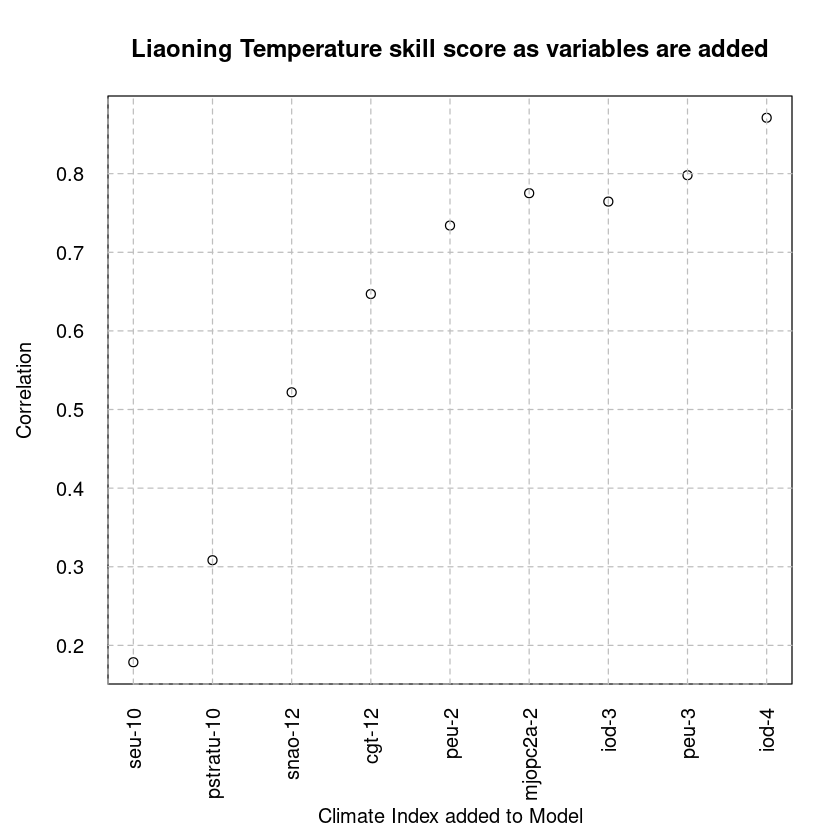

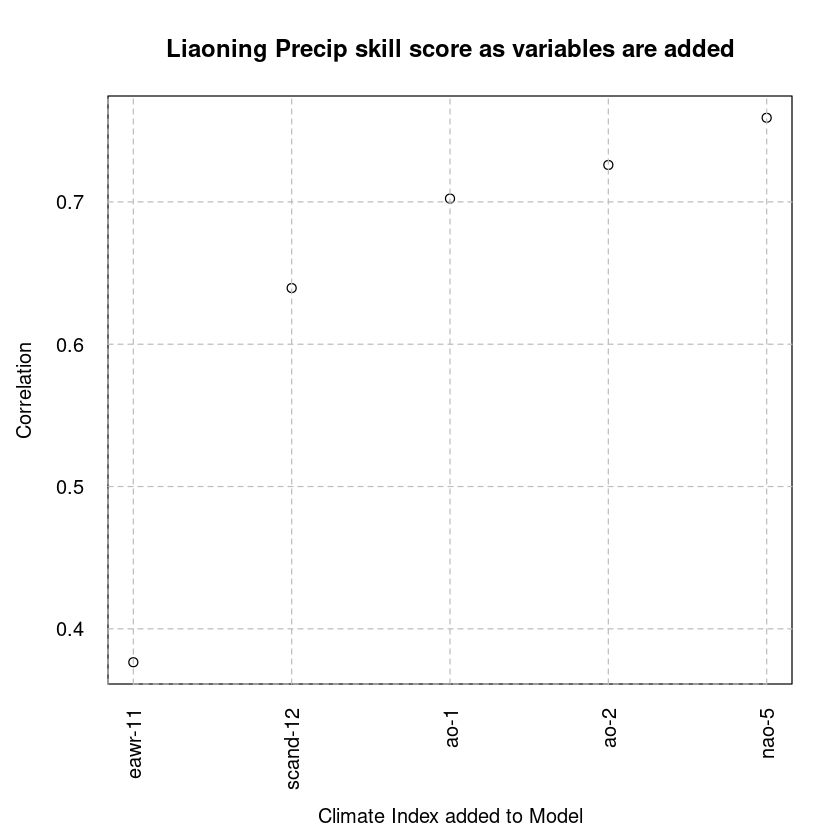

[1] "No need for plot with 1 precip predictor for Jilin"
[1] "Total skill score Jilin precip =  0.377532769197189"


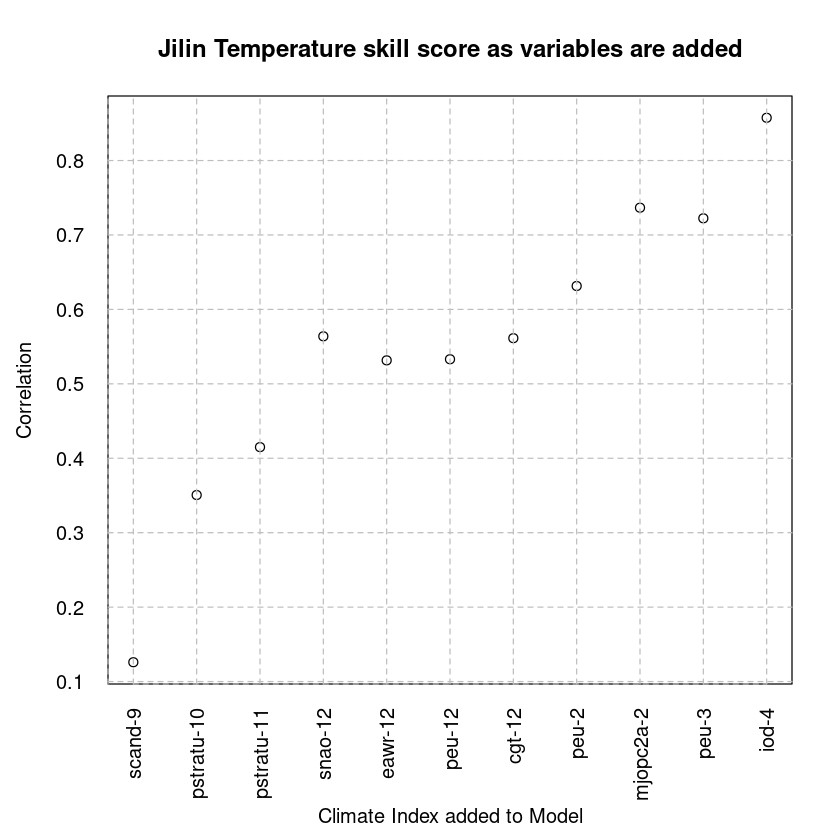

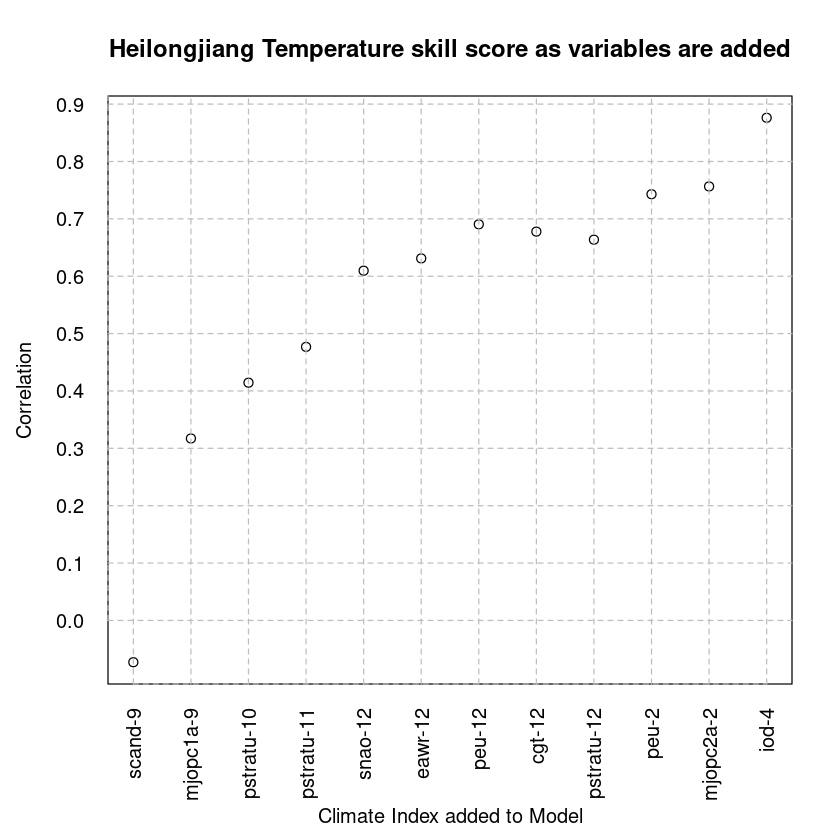

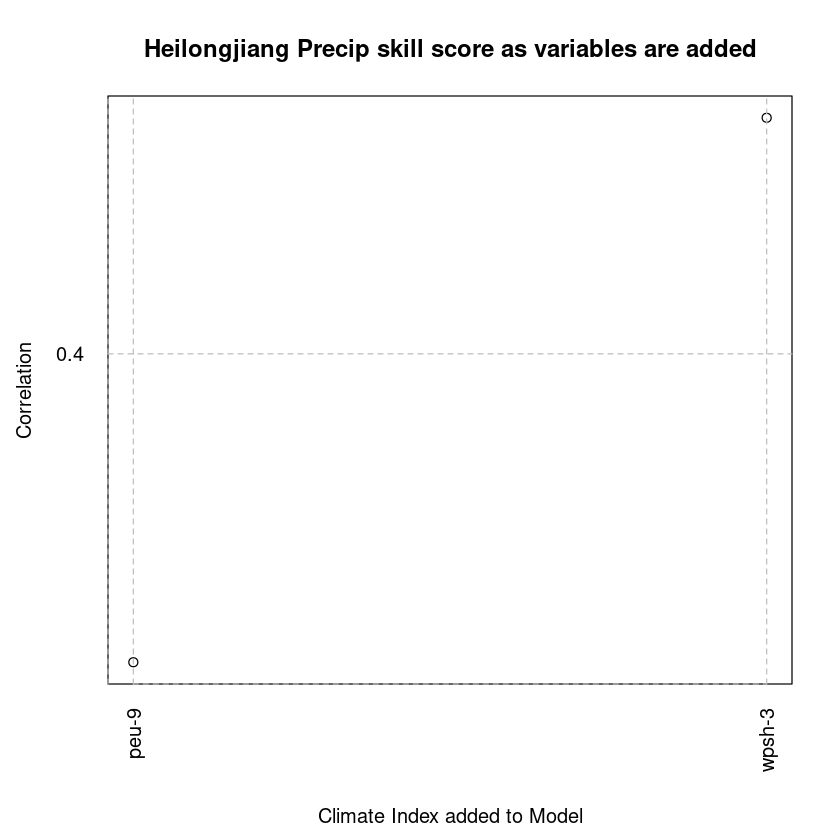

In [223]:
all_scores_T = c()
all_scores_P = c()
t_loocv = create_empty_dataframe(rownames(temp_jja), regs)
p_loocv = create_empty_dataframe(rownames(temp_jja), regs)
years <- rownames(cindex_df)

for (k in 1:length(regs)) {
    scores = as.numeric(0)
    scores_P = as.numeric(0)
    # get the T and P indexs of significant varibles 
    t_inds = gsub("[[:punct:]]", "-", t_parent[[k]])
    p_inds = gsub("[[:punct:]]", "-", p_parent[[k]])

    if (length(t_inds) == 1) {
        print(paste("No need for plot with 1 temperature predictor for",regs[k]))
        print(paste("Total skill score", regs[k], "temperature = ", cor(t_loocv_red[, k], temp_anoms[,k])))
    } else { 
    df_for_temp_prediction = sort_df_cols_on_month(cindex_df[,t_inds], mon_list)
    
    
    for (col_index in 1:length(colnames(df_for_temp_prediction))) {
    new_var_added_T = colnames(df_for_temp_prediction)[col_index]
    df_to_use_T = data.frame(df_for_temp_prediction[, 1:col_index])
    colnames(df_to_use_T) <- colnames(df_for_temp_prediction)[1:col_index]
    
    
        for (y in 1:length(years)) {
            #print(y)
            rind = y
            tt = 1:length(temp_jja[-rind,k]) 
            lmmodt = lm(temp_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
            lmmodp = lm(temp_jja[-rind,k] ~ tt)
            

            # get mean T/P for the missing year    
            ttout_of_sample_data <- data.frame(tt = t(rind))
            tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit

            if (length(t_inds) > 0) {
                tmod = automate_predict_new_test("t", lmmodt$residuals, df_to_use_T[-rind, ], df_to_use_T[rind,])
                tmod_fit = tmod$model$fitted.values
                t_loocv[y,k] = tmod$pred

            }

        }
    
    scores = rbind(scores, cbind(new_var_added_T, cor(t_loocv[, k], temp_anoms[,k])))
    }
    scores = scores[-1,]
    scores <- data.frame(scores)
    colnames(scores) <- c('Variable_added', 'Score')
    rownames(scores) <- scores$Variable_added
    #print(scores$Score)
    all_scores_T[[regs[k]]] = scores
    fig.dim = c(8, 8)
    par(mar=c(6.5,4.5,4,2))
    plot(x = 1:length(scores$Variable_added), 
         y = as.numeric(as.character(scores$Score)),
         xaxt = "n",
         yaxt = "n",
        ylab="Correlation",
        xlab="")
    axis(1, at = seq(1,length(scores$Variable_added),1),
         labels=scores$Variable_added , las=2, tck = 1, lty = 2, col = "grey")
    axis(2, at = seq(0,1,0.1), las=2, tck = 1, lty = 2, col = "grey")
    title(xlab = "Climate Index added to Model", line = 5) 
    title(main = paste(regs[k],"Temperature skill score as variables are added"))
    }
    
    if (length(p_inds) == 1) {
        print(paste("No need for plot with 1 precip predictor for",regs[k]))
        print(paste("Total skill score", regs[k], "precip = ", cor(p_loocv_red[, k], precip_anoms[,k])))
    } else { 
    df_for_precip_prediction = sort_df_cols_on_month(cindex_df[,p_inds], mon_list)
        
    
    for (col_index in 1:length(colnames(df_for_precip_prediction))) {
    new_var_added_P = colnames(df_for_precip_prediction)[col_index]
    df_to_use_P = data.frame(df_for_precip_prediction[, 1:col_index])
    colnames(df_to_use_P) <- colnames(df_for_precip_prediction)[1:col_index]
    
    
        for (y in 1:length(years)) {
            #print(y)
            rind = y
            tt = 1:length(precip_jja[-rind,k]) 
            lmmodt = lm(precip_jja[-rind,k] ~ tt) # temp_jja[-rind, k] ~ tt # gets all the years other than -rind for that area
            lmmodp = lm(precip_jja[-rind,k] ~ tt)
            

            # get mean T/P for the missing year    
            ttout_of_sample_data <- data.frame(tt = t(rind))
            pmean_pred = predict(lmmodp, ttout_of_sample_data, se.fit = TRUE)$fit

            if (length(p_inds) > 0) {
                pmod = automate_predict_new_test("p", lmmodp$residuals, df_to_use_P[-rind,], df_to_use_P[rind,])
                pmod_fit = pmod$model$fitted.values
                p_loocv[y,k] = pmod$pred
            }

        }
    
    scores_P= rbind(scores_P, cbind(new_var_added_P, cor(p_loocv[, k], precip_anoms[,k])))
    }
    scores_P = scores_P[-1,]
    scores_P <- data.frame(scores_P)
    colnames(scores_P) <- c('Variable_added', 'Score')
    rownames(scores_P) <- scores_P$Variable_added
    #print(scores$Score)
    all_scores_P[[regs[k]]] = scores_P
    fig.dim = c(8, 8)
    par(mar=c(6.5,4.5,4,2))
    plot(x = 1:length(scores_P$Variable_added), 
         y = as.numeric(as.character(scores_P$Score)),
         xaxt = "n",
         yaxt = "n",
        ylab="Correlation",
        xlab="")
    axis(1, at = seq(1,length(scores_P$Variable_added),1),
         labels=scores_P$Variable_added , las=2, tck = 1, lty = 2, col = "grey")
    axis(2, at = seq(0,1,0.1), las=2, tck = 1, lty = 2, col = "grey")
    title(xlab = "Climate Index added to Model", line = 5) 
    title(main = paste(regs[k],"Precip skill score as variables are added"))
    }
}

# Explainability plots 

In [ ]:
# create plot to show variable selection
tpc = prcomp((temp_anoms))
ppc = prcomp((precip_anoms))

tvar_exp = 100.0*signif(tpc$sdev/sum(tpc$sdev), digits=2)
pvar_exp = 100.0*signif(ppc$sdev/sum(ppc$sdev), digits=2)

#  correlated temperature predictors with the first two 
tcors1_all = cor(cindex_df, tpc$x[,1])
tcors2_all = cor(cindex_df, tpc$x[,2])
tcors1 = cor(cindex_df[,t_inds_all], tpc$x[,1])
tcors2 = cor(cindex_df[,t_inds_all], tpc$x[,2])

pcors1_all = cor(cindex_df, ppc$x[,1])
pcors2_all = cor(cindex_df, ppc$x[,2])
pcors1 = cor(cindex_df[,p_inds_all], ppc$x[,1])
pcors2 = cor(cindex_df[,p_inds_all], ppc$x[,2])


#  dev.new()
#png(paste('./', region,'_tpca_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""),width=16.25,height=12.25,units="in",res=400)
#  , bg = "transparent"
#  par(mfrow=c(1,2))
par(mar=c(7,7,4,4))
plot(sqrt(tpc$rotation[,1]^2), sqrt(tpc$rotation[,2]^2), xlim=c(0,0.8), ylim=c(0,0.9),
     cex=3, cex.lab = 2.5, cex.axis=2.5, 
     xlab=paste("Correlation with Temperature - PC1 (", tvar_exp[1], "%)", sep=""), 
     ylab=paste("Correlation with Temperature PC2 (", tvar_exp[2], "%)", sep=""), pch=1)
text(sqrt(tpc$rotation[,1]^2), sqrt(tpc$rotation[,2]^2), labels=regs, cex= 2.0, pos=3)
points(sqrt(tcors1_all^2), sqrt(tcors2_all^2), col='gray', pch=2)
points(sqrt(tcors1^2), sqrt(tcors2^2), col='orange', pch=2)
text(sqrt(tcors1^2), sqrt(tcors2^2), labels=colnames(cindex_df[, t_inds_all]), cex= 2.0, pos=3)
legend("topleft", cex=2.0, legend = c("Obs Temp", "Climate Indices", "Climate Indices (selected)"),
       pch=c(1,2,2), col=c("black", "gray", "orange"))
#dev.off()


#png(paste('./', region,'_ppca_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""),width=16.25,height=12.25,units="in",res=300)
par(mar=c(7,7,4,4))
plot(sqrt(ppc$rotation[,1]^2), sqrt(ppc$rotation[,2]^2), xlim=c(0,0.8), ylim=c(0,0.9), 
     cex=2, cex.lab = 2, cex.axis=2, 
     xlab=paste("Correlation with Precipitation - PC1 (", pvar_exp[1], "%)", sep=""),
     ylab=paste("Correlation with Precipitation - PC2 (", pvar_exp[2], "%)", sep=""), pch=1)
text(sqrt(ppc$rotation[,1]^2), sqrt(ppc$rotation[,2]^2), labels=regs, cex= 1.5, pos=3)
points(sqrt(pcors1_all^2), pcors2_all^2, col='gray', pch=2)
points(sqrt(pcors1^2), sqrt(pcors2^2), col='orange', pch=2)
text(sqrt(pcors1^2), sqrt(pcors2^2), labels=colnames(cindex_df[, p_inds_all]), cex= 1.5, pos=3)
legend("topleft", legend = c("Obs Precip", "Climate Indices", "Climate Indices (selected)"), 
       pch=c(1,2,2), col=c("black", "gray", "orange"), cex=1.5)
#dev.off()

### Bootstrapping confidence intervals 

In [24]:
library(boot)

In [25]:
boot_cor <- function(data, indices) {
    d <- data[indices,]
    cor()
    return (cor_whatever)
}

In [26]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
0.4767537,-0.07799843,-0.53412111
1.0461054,1.81619148,2.06508026
-0.1926158,-1.65087332,-2.06402876
0.3694542,0.28934417,-0.02428095
-0.1619110,0.11110493,0.11437196
-1.1381192,-0.94495550,-0.37800865


In [20]:

fcast_no_jet = read.csv("/net/home/h06/epope/climate_security/python_code/HCCP/china_fcast_temp_anoms_JJA_lag_0.csv"
         , header = TRUE,sep = ",", stringsAsFactors = FALSE)  

In [21]:
head(fcast_no_jet[, -1])

,Liaoning,Jilin,Heilongjiang
,<dbl>,<dbl>,<dbl>
1,0.28304739,0.6290482,-0.03177261
2,0.63285838,0.4775292,0.94215132
3,0.07666741,-0.8564212,-0.56686453
4,0.04303112,0.1457353,0.57736689
5,0.42814734,0.9633850,0.80497997
6,-0.28179202,-0.7051890,-0.10653735


In [22]:
liaoning_data = cbind(fcast_no_jet[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(fcast_no_jet[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(fcast_no_jet[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

In [23]:
cor(liaoning_data[,1], liaoning_data[,2])

[1] 0.8211218

In [38]:
function_1 <- function(data, i){
 d <- data[i,] 
 return(cor(d[,1], d[,2]))
}

#### Liaoning 

In [64]:
set.seed(1)
bootstrap_correlation <- boot(liaoning_data,function_1,R=1000)

In [65]:
bootstrap_correlation


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.8211218 -0.004189638  0.06141371

In [67]:
boot.ci(boot.out=bootstrap_correlation)

Warning message in boot.ci(boot.out = bootstrap_correlation):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_correlation)

Intervals : 
Level      Normal              Basic         
95%   ( 0.7049,  0.9457 )   ( 0.7394,  0.9729 )  

Level     Percentile            BCa          
95%   ( 0.6694,  0.9029 )   ( 0.6363,  0.8978 )  
Calculations and Intervals on Original Scale

#### Jilin 

In [72]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.7420534 0.004217224  0.07536096


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.5901,  0.8855 )   ( 0.6150,  0.9058 )  

Level     Percentile            BCa          
95%   ( 0.5783,  0.8691 )   ( 0.4800,  0.8524 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable


#### Heilongjiang

In [74]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6967452 0.004085927  0.06454376


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   ( 0.5662,  0.8192 )   ( 0.5731,  0.8230 )  

Level     Percentile            BCa          
95%   ( 0.5705,  0.8204 )   ( 0.5572,  0.8077 )  
Calculations and Intervals on Original Scale


## with Jets 

In [33]:
fcast_jet = read.csv("/net/home/h06/epope/climate_security/python_code/HCCP/china_fcast_temp_anoms_red_JJA_lag_0.csv"
         , header = TRUE,sep = ",", stringsAsFactors = FALSE)  

In [34]:
head(fcast_jet)

,X,Liaoning,Jilin,Heilongjiang
,<int>,<dbl>,<dbl>,<dbl>
1,1981,0.1484943,0.442664534,0.35671256
2,1982,0.4940587,0.486733872,0.57499719
3,1983,-0.1694563,-0.546983294,-0.86534339
4,1984,-0.1137297,-0.002702875,-0.02792253
5,1985,-0.9596029,-0.598009051,-0.39688159
6,1986,0.1826624,-0.064899170,0.19258362


In [35]:
liaoning_data = cbind(fcast_jet[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(fcast_jet[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(fcast_jet[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

#### Liaoning 

In [41]:
set.seed(1)
bootstrap_liaoning <- boot(liaoning_data,function_1,R=1000)
print(bootstrap_liaoning)
print(boot.ci(boot.out=bootstrap_liaoning))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6186866 0.002705464  0.09200868


Warning message in boot.ci(boot.out = bootstrap_liaoning):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_liaoning)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4356,  0.7963 )   ( 0.4585,  0.8330 )  

Level     Percentile            BCa          
95%   ( 0.4043,  0.7789 )   ( 0.3695,  0.7634 )  
Calculations and Intervals on Original Scale


In [86]:
0.62 + 0.18

[1] 0.8

#### Jilin

In [42]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6309198 0.008517417  0.07996893


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4657,  0.7791 )   ( 0.4819,  0.7896 )  

Level     Percentile            BCa          
95%   ( 0.4722,  0.7799 )   ( 0.3864,  0.7582 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable


In [88]:
0.65 + 0.16

[1] 0.81

#### Heilongjiang 

In [43]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.5974958 0.007689333  0.07639934


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4401,  0.7395 )   ( 0.4521,  0.7521 )  

Level     Percentile            BCa          
95%   ( 0.4429,  0.7429 )   ( 0.4052,  0.7209 )  
Calculations and Intervals on Original Scale


# Seasonal forecast  

In [45]:
datadir = '/data/users/ncreaser/CSSP_china/data/seasonal_forecast/DePreSys_NE_China_provinces_weighted_detrended_1981_2016.csv'
depresys = read.csv(datadir
         , header = TRUE,sep = ",", stringsAsFactors = FALSE) 

In [47]:
liaoning_data = cbind(depresys[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(depresys[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(depresys[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

In [48]:
set.seed(1)
bootstrap_liaoning <- boot(liaoning_data,function_1,R=1000)
print(bootstrap_liaoning)
print(boot.ci(boot.out=bootstrap_liaoning))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.2696603 0.007538836   0.1343295


Warning message in boot.ci(boot.out = bootstrap_liaoning):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_liaoning)

Intervals : 
Level      Normal              Basic         
95%   (-0.0012,  0.5254 )   ( 0.0085,  0.5352 )  

Level     Percentile            BCa          
95%   ( 0.0041,  0.5308 )   (-0.0387,  0.4985 )  
Calculations and Intervals on Original Scale


In [49]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.2924243 -0.0006353441   0.1422674


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0142,  0.5719 )   ( 0.0295,  0.5958 )  

Level     Percentile            BCa          
95%   (-0.0109,  0.5553 )   ( 0.0057,  0.5577 )  
Calculations and Intervals on Original Scale


In [50]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.2445439 0.0007686634   0.1668556


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   (-0.0833,  0.5708 )   (-0.0734,  0.5648 )  

Level     Percentile            BCa          
95%   (-0.0757,  0.5625 )   (-0.0893,  0.5510 )  
Calculations and Intervals on Original Scale
